# Note: This notebook takes from the webinar on stardist [link text](https://www.youtube.com/watch?v=Amn_eHRGX5M)

In [1]:
from google.colab import drive
#drive.mount('/content/drive')

In [2]:
!pip install stardist
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 2.5 MB/s eta 0:00:00


In [3]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

from skimage import io
import os


import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input

from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

import tensorflow as tf
import scipy
import scipy.ndimage as ndi
import numpy as np
import skimage
from skimage import io, filters
from skimage import data, img_as_float
import skimage.util.noise as noise
from skimage.restoration import denoise_bilateral
import matplotlib.pyplot as plt
import os
import math

import skimage
from skimage import img_as_ubyte
from skimage import exposure
from skimage import filters
from skimage import io
from skimage import color
from skimage import feature
from skimage import segmentation
from skimage import morphology
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt

from skimage import io, color, exposure, morphology, segmentation, img_as_float, restoration

%matplotlib inline

np.random.seed(42)
lbl_cmap = random_label_cmap()

Import the data from DataCollection folder

---



1. Using a folder that includes the images and label masks for the training and test cases. The folder has the following structure:

```
data
 |-mydata
 | |-train
 | | |-images
 | | | | image1.tif
 | | | | image2.tif
 | | | | ...
 | | |-masks
 | | | | mask1.tif
 | | | | mask2.tif
 | | | | ...
 | |-test
 | | |-images
 | | | | ...
 | | |-masks
 | | | | ...
 ```


```

In [4]:
import os
from glob import glob
#function to move our slices  to there respective folders. thank you brandon ^_^ saddly this is a leftover function not used

def move_file_set(src_dir: str, dest_dir: str, pattern: str) -> None:
    """
    Move all files in src_dir directory where the file name matches
    the given pattern to the dest_dir directory. Will print the
    number of files moved.
    :param src_dir: The absolute path for the source directory
    :param dest_dir: The absolute path for the destination directory
    :param pattern: A file name pattern to match against (* is wildcard)
                    Ex: to get all files with "move" in the filename,
                    pattern would be "*move*".
    :return: None
    """
    pattern = "*" if len(pattern) == 0 else pattern  # error checking
    move_count: int = 0
    for old_path in glob(os.path.join(src_dir, pattern)):
        new_path = os.path.join(dest_dir, os.path.basename(old_path))
        os.replace(old_path, new_path)
        move_count += 1
    print(f"Number of Files Move: {move_count}")


In [5]:
#ben's crop image function
def crop_images(original, mask, num_width, num_height, size):
    crops = []
    for i in range(num_height):
        for j in range(num_width):
            # Calculate the starting and ending indices for the crop
            start_x = j * size[0]
            start_y = i * size[1]
            end_x = start_x + size[0]
            end_y = start_y + size[1]

            # Crop the original and mask images to the same area using array slicing
            crop_original = original[start_y:end_y, start_x:end_x]
            crop_mask = mask[start_y:end_y, start_x:end_x]

            # Append the crops to the list
            crops.append({
                'original': crop_original,
                'mask': crop_mask,
                'position': (i, j)
            })

    return crops

In [6]:
import PIL
from PIL import Image
import numpy as n
import os, glob, math
import patoolib

newpath = r'testImages'
if not os.path.exists(newpath):
    patoolib.extract_archive("testImages.zip", outdir= os.getcwd())

newpath = r'originalDirectory_256x256'
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'maskDirectory_256x256'
if not os.path.exists(newpath):
    os.makedirs(newpath)

imgDir2 = 'originalDirectory_256x256'
imgDir1 = 'maskDirectory_256x256'

# makes directories where files will be stored.
output_dir1 = os.path.join(os.getcwd(),imgDir1)
print(output_dir1)
output_dir2 = os.path.join(os.getcwd(),imgDir2)
print(output_dir2)


# Define the size of the crops
crop_size = (256, 256)
#crop_size = (100, 100)

# Crop the images
OriginalImgPaths = []

for file in glob.glob("/content/testImages/originals/*.tif"):
                OriginalImgPaths.append(file)

print("OriginalImgPaths",OriginalImgPaths)

maskImgPaths = []

for file in glob.glob("/content/testImages/masks/*.tif"):
               maskImgPaths.append(file)

print("maskImgPaths",maskImgPaths)

counter = 0
for i in range(len(maskImgPaths)):

  original_img = io.imread(OriginalImgPaths[i])
  mask_img = io.imread(maskImgPaths[i])

 #apply some preprocessing to the original
  # Convert the image to float
  img_float = img_as_float(original_img)

  # Perform histogram equalization
  equalized_img = exposure.equalize_hist(img_float)

  # Apply additional contrast enhancement
  contrast_img = exposure.rescale_intensity(equalized_img)
  # Apply Chambolle denoising filter
  # The weight 'alpha' parameter controls the degree of smoothing.
  # alpha set to value of 0.05
  chambolle_img = restoration.denoise_tv_chambolle(contrast_img, weight=0.05)

  original_img = chambolle_img

  print("Shape of original image:", original_img.shape)
  print("Shape of mask image:", mask_img.shape)

  # Calculate the number of crops that fit into the images
  original_height, original_width = original_img.shape[:2]
  n_crops_width = original_width // crop_size[0]
  n_crops_height = original_height // crop_size[1]

  # Calculate the total number of 256x256 crops from the image
  total_crops = n_crops_width * n_crops_height
  print("\nTotal number of cropped images:", total_crops)

  # Print their values to see what we workin with lol
  print("original_height:", original_height)
  print("original_width:", original_width)
  print("n_crops_width:", n_crops_width)
  print("n_crops_height:", n_crops_height)

  crops = crop_images(original_img, mask_img, n_crops_width, n_crops_height, crop_size)

  output_files = []
  for i, crop in enumerate(crops):

      original_crop_path = f'/content/originalDirectory_256x256/original_crop{counter}.tif'
      print("original_crop_path",original_crop_path)
      mask_crop_path = f'/content/maskDirectory_256x256/mask_crop{counter}.tif'
      print("mask_crop_path",mask_crop_path)
      counter = counter + 1
      io.imsave(original_crop_path, crop['original'])
      io.imsave(mask_crop_path, crop['mask'])
      output_files.append((original_crop_path, mask_crop_path))



# Return the paths of the first few cropped images for display
#output_files[:5]  # Show paths of the first 5 sets of cropped images

INFO patool: Extracting testImages.zip ...
INFO:patool:Extracting testImages.zip ...
INFO patool: running /usr/bin/7z x -o/content -- testImages.zip
INFO:patool:running /usr/bin/7z x -o/content -- testImages.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... testImages.zip extracted to `/content'.
INFO:patool:... testImages.zip extracted to `/content'.


/content/maskDirectory_256x256
/content/originalDirectory_256x256
OriginalImgPaths ['/content/testImages/originals/band_image.tif']
maskImgPaths ['/content/testImages/masks/band-image.tif']
Shape of original image: (2028, 3523)
Shape of mask image: (2028, 3523)

Total number of cropped images: 91
original_height: 2028
original_width: 3523
n_crops_width: 13
n_crops_height: 7
original_crop_path /content/originalDirectory_256x256/original_crop0.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop0.tif
original_crop_path /content/originalDirectory_256x256/original_crop1.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop1.tif
original_crop_path /content/originalDirectory_256x256/original_crop2.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop2.tif
original_crop_path /content/originalDirectory_256x256/original_crop3.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop3.tif
original_crop_path /content/originalDirectory_256x256/original_crop4.tif
mask_crop_path

<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop7.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop8.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop10.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop21.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop23.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop34.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop36.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop37.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop48.tif is a low contrast image
<ipython-input-6-122f8f874b34>

original_crop_path /content/originalDirectory_256x256/original_crop74.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop74.tif
original_crop_path /content/originalDirectory_256x256/original_crop75.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop75.tif
original_crop_path /content/originalDirectory_256x256/original_crop76.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop76.tif
original_crop_path /content/originalDirectory_256x256/original_crop77.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop77.tif
original_crop_path /content/originalDirectory_256x256/original_crop78.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop78.tif
original_crop_path /content/originalDirectory_256x256/original_crop79.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop79.tif
original_crop_path /content/originalDirectory_256x256/original_crop80.tif
mask_crop_path /content/maskDirectory_256x256/mask_crop80.tif
original_crop_path /content/originalDirectory_25

<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop85.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop86.tif is a low contrast image
<ipython-input-6-122f8f874b34> (99): /content/maskDirectory_256x256/mask_crop87.tif is a low contrast image


In [7]:

from glob import glob

image_paths = sorted(glob('/content/originalDirectory_256x256/*.tif'))
#print("X",X)
mask_paths = sorted(glob('/content/maskDirectory_256x256/*.tif'))

X = [io.imread(image_path) for image_path in image_paths]
Y = [io.imread(mask_path) for mask_path in mask_paths]

print("X[0].shape",X[0].shape)
print("Y[0].shape",Y[0].shape)


n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]


X[0].shape (256, 256)
Y[0].shape (256, 256)


Normalize images and fill small label holes.




In [8]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 91/91 [00:00<00:00, 846.10it/s]


Split into train and validation datasets.

In [9]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = np.array([X[i] for i in ind_val]), np.array([Y[i] for i in ind_val])
X_trn, Y_trn = np.array([X[i] for i in ind_train]), np.array([Y[i] for i in ind_train])
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  91
- training:        77
- validation:      14


Training data consists of pairs of input image and label instances.

In [10]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

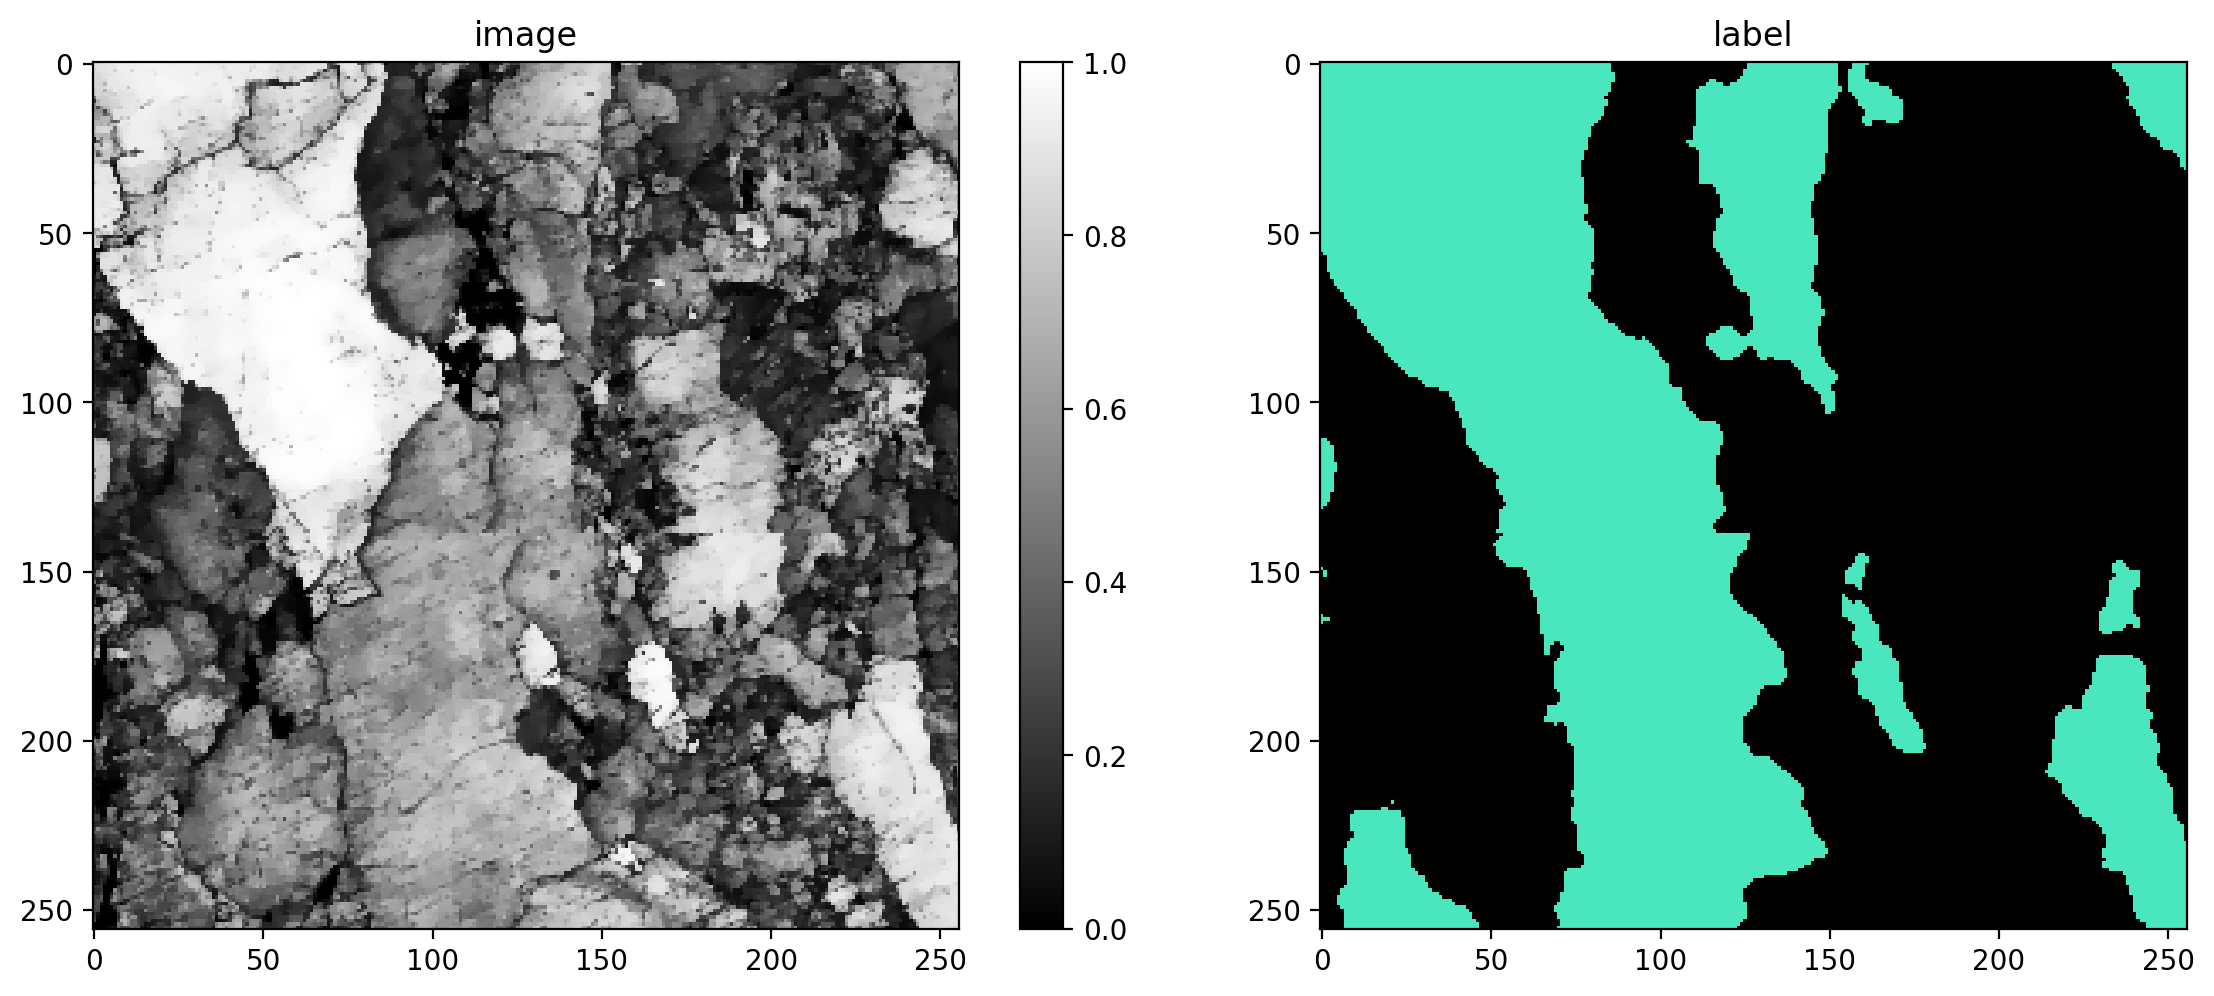

In [11]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [12]:
print(Config2D.__doc__)

Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [13]:
#if this does not display stats and give errors make sure your docker is launched with gup support
#https://research.google.com/colaboratory/local-runtimes.html
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Thu Dec 14 04:31:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.88       Driver Version: 528.36       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     3W /  30W |      0MiB /  6144MiB |      0%      Default |
|                               |       

In [14]:
import torch
torch.cuda.is_available()

True

In [15]:

#import torch
#import gputools
#https://stackoverflow.com/questions/50560395/how-to-install-cuda-in-google-colab-gpus
#https://forum.image.sc/t/problems-setting-up-environment-to-use-stardist-wtih-gputools-opencl/54030/6
#https://www.analyticsvidhya.com/blog/2021/05/a-complete-hands-on-guide-to-train-your-neural-network-model-on-google-colab-gpu/

use_gpu = True and torch.cuda.is_available()

if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    print("activating gpu using torch")
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)


activating gpu using torch


In [16]:

# 256 Trying agian with lots of rays
n_rays = 126

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (1,1)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
    train_shape_completion  = False,
    train_learning_rate = 0.003,
    train_background_reg = 0.00001,
    train_patch_size = (126, 126),
)
print(conf)
vars(conf)

Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=127, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=126, grid=(1, 1), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(126, 126), train_background_reg=1e-05, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_rate=0.003, train_batch_size=4, train_n_val_patches=None, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 127,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 126,
 'grid': (1, 1),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (126, 126),
 'train_background_reg': 1e-05,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.003,


# Data Augmentation

Define a function/callable that applies augmentation to each batch of the data generator.  
Use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) images (can disable augmentation by setting `augmenter = None`).

In [17]:
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.2,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    # x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

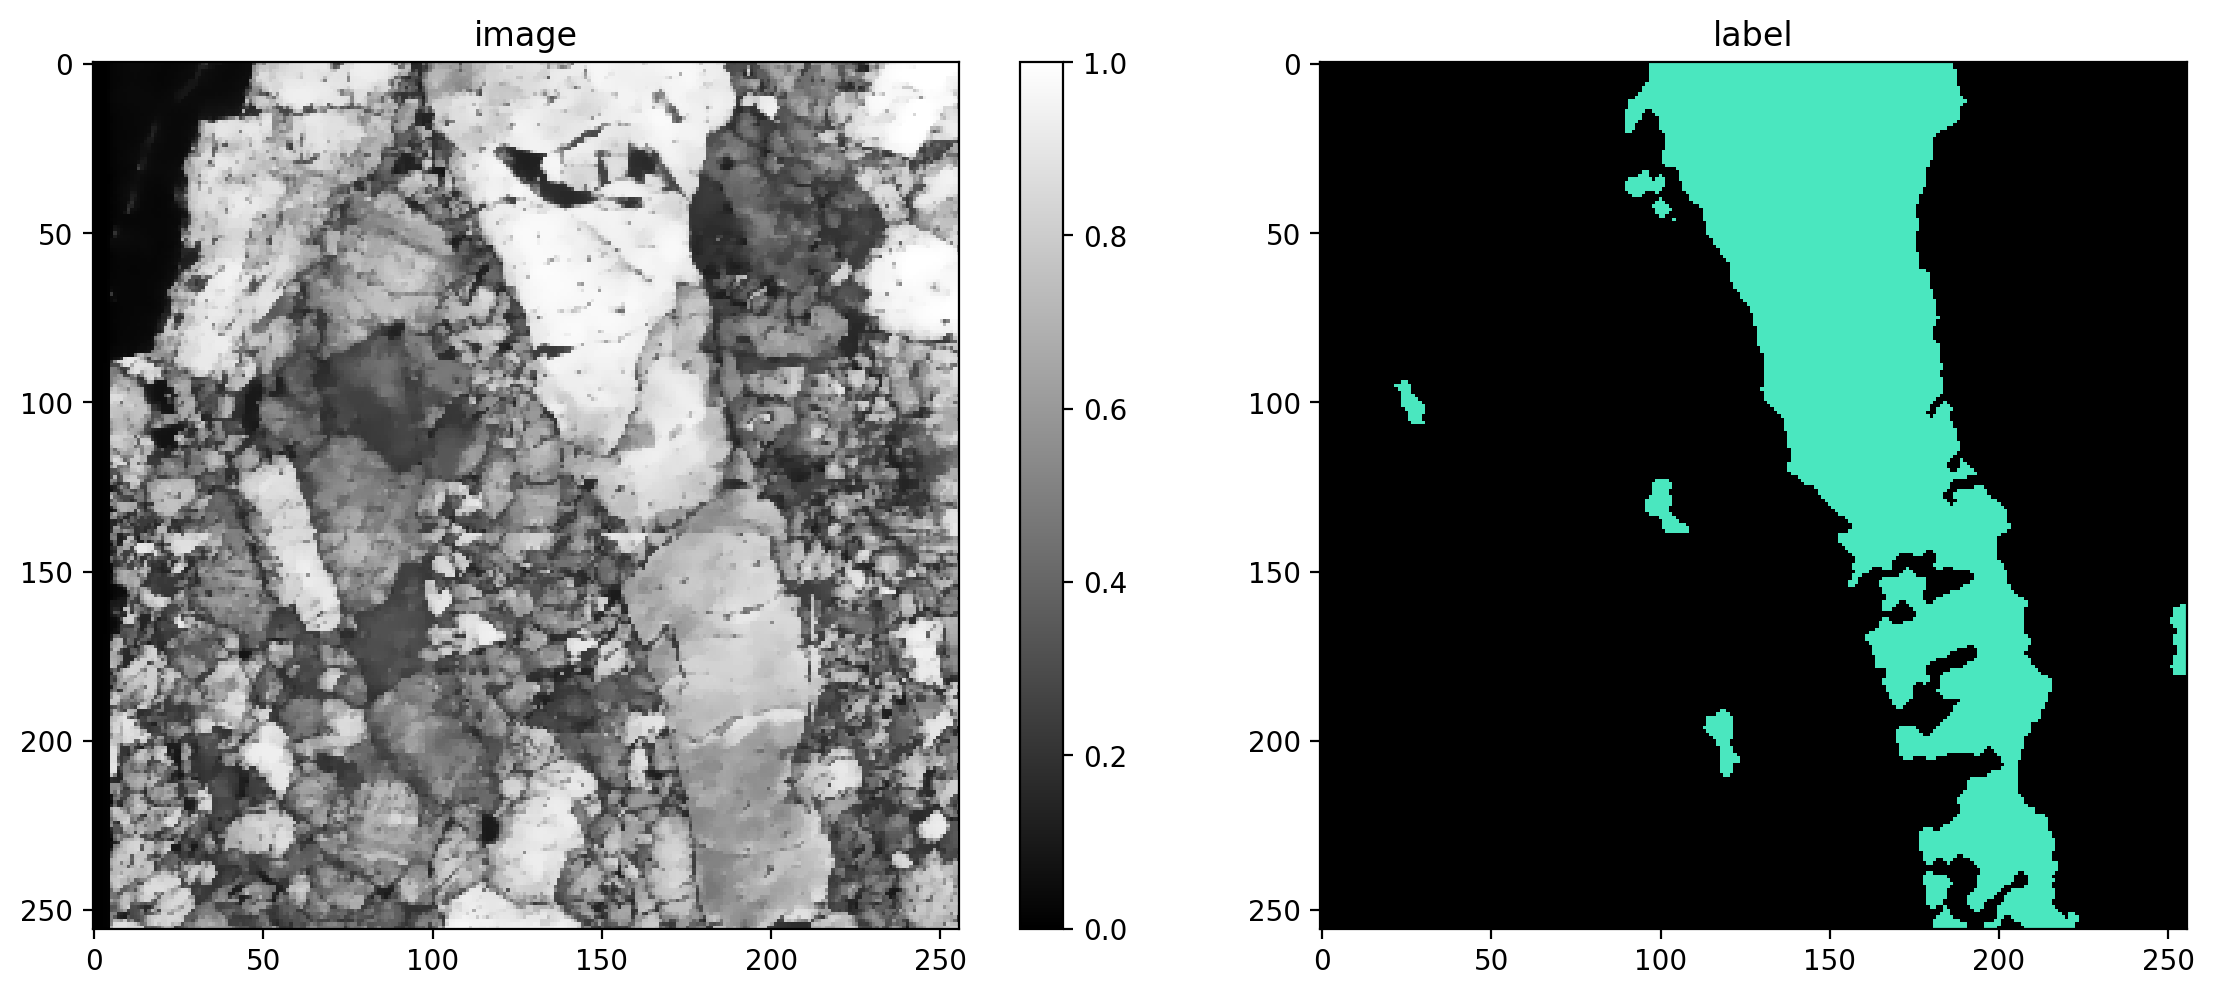

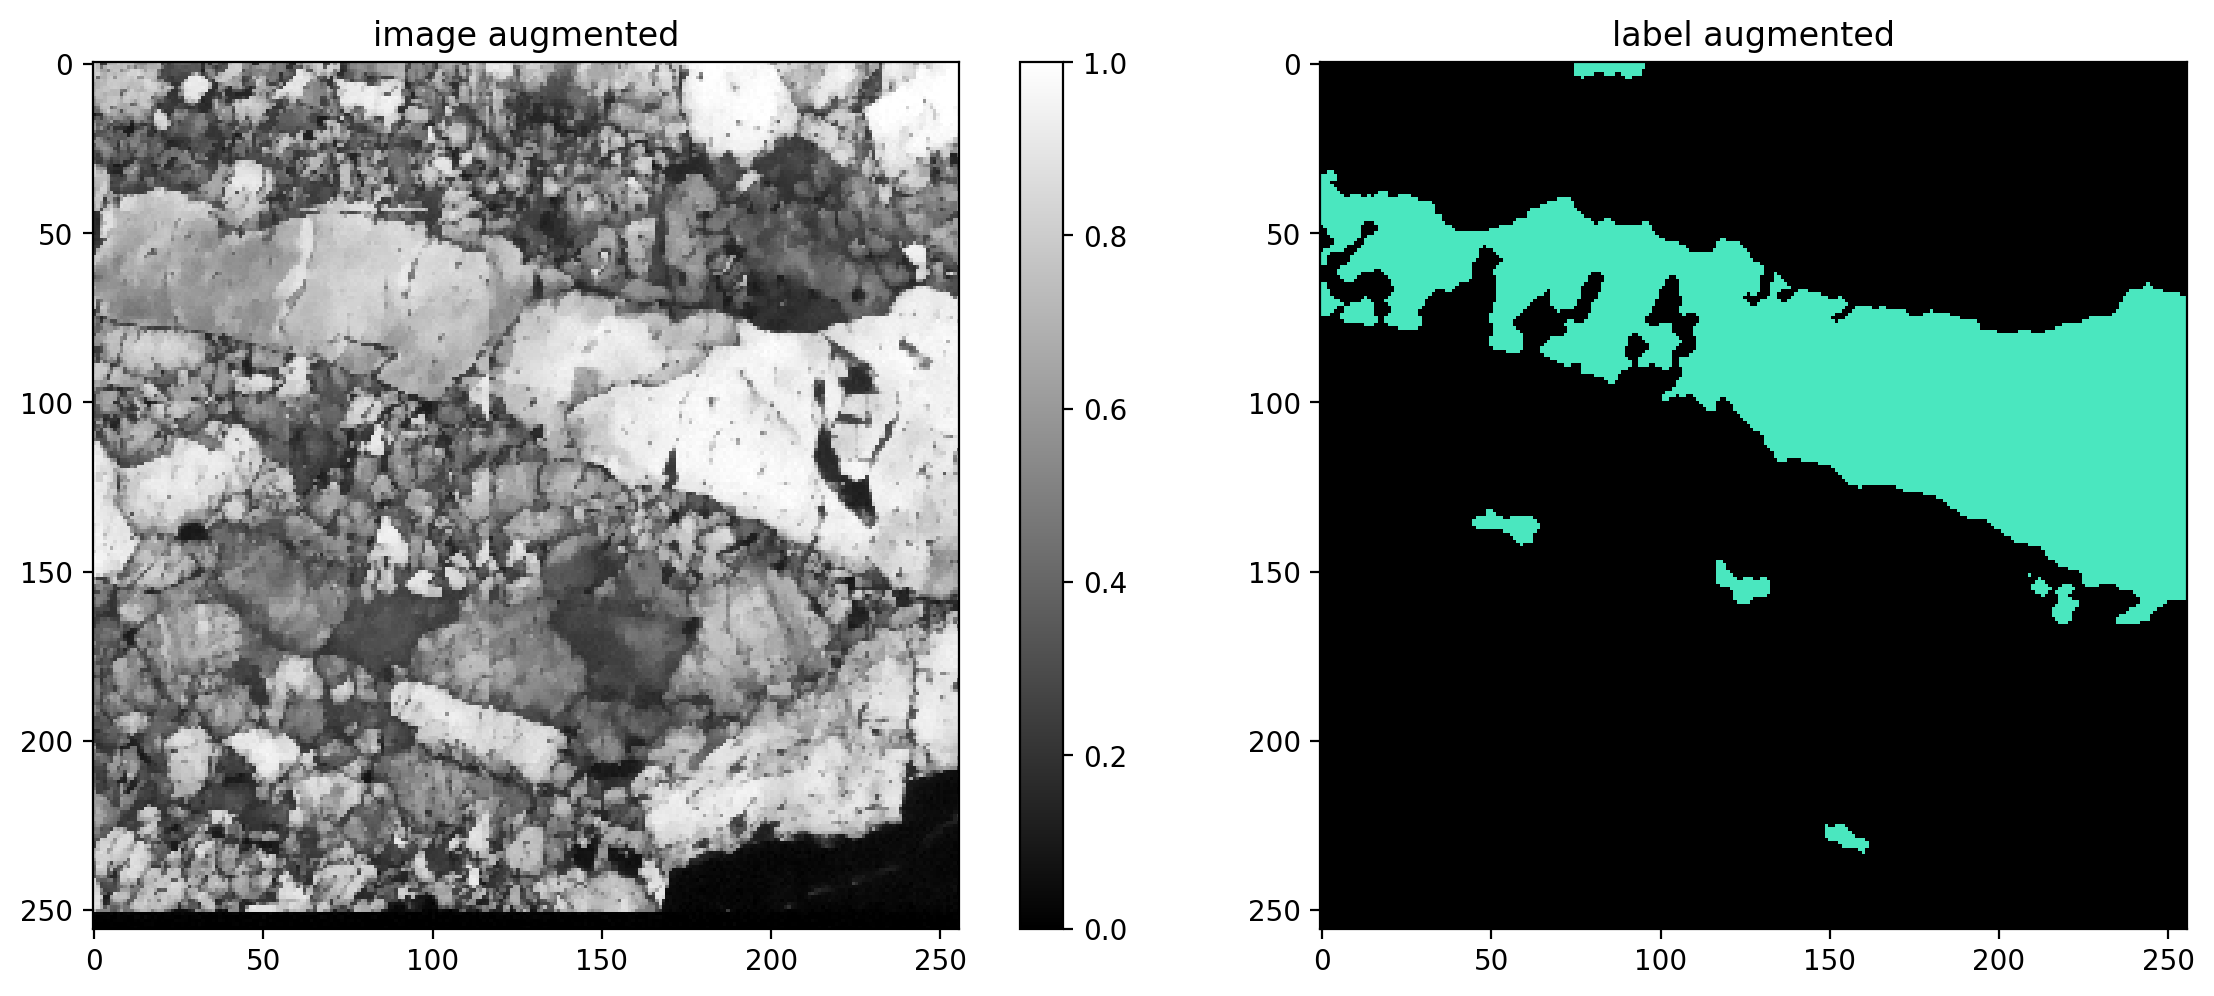

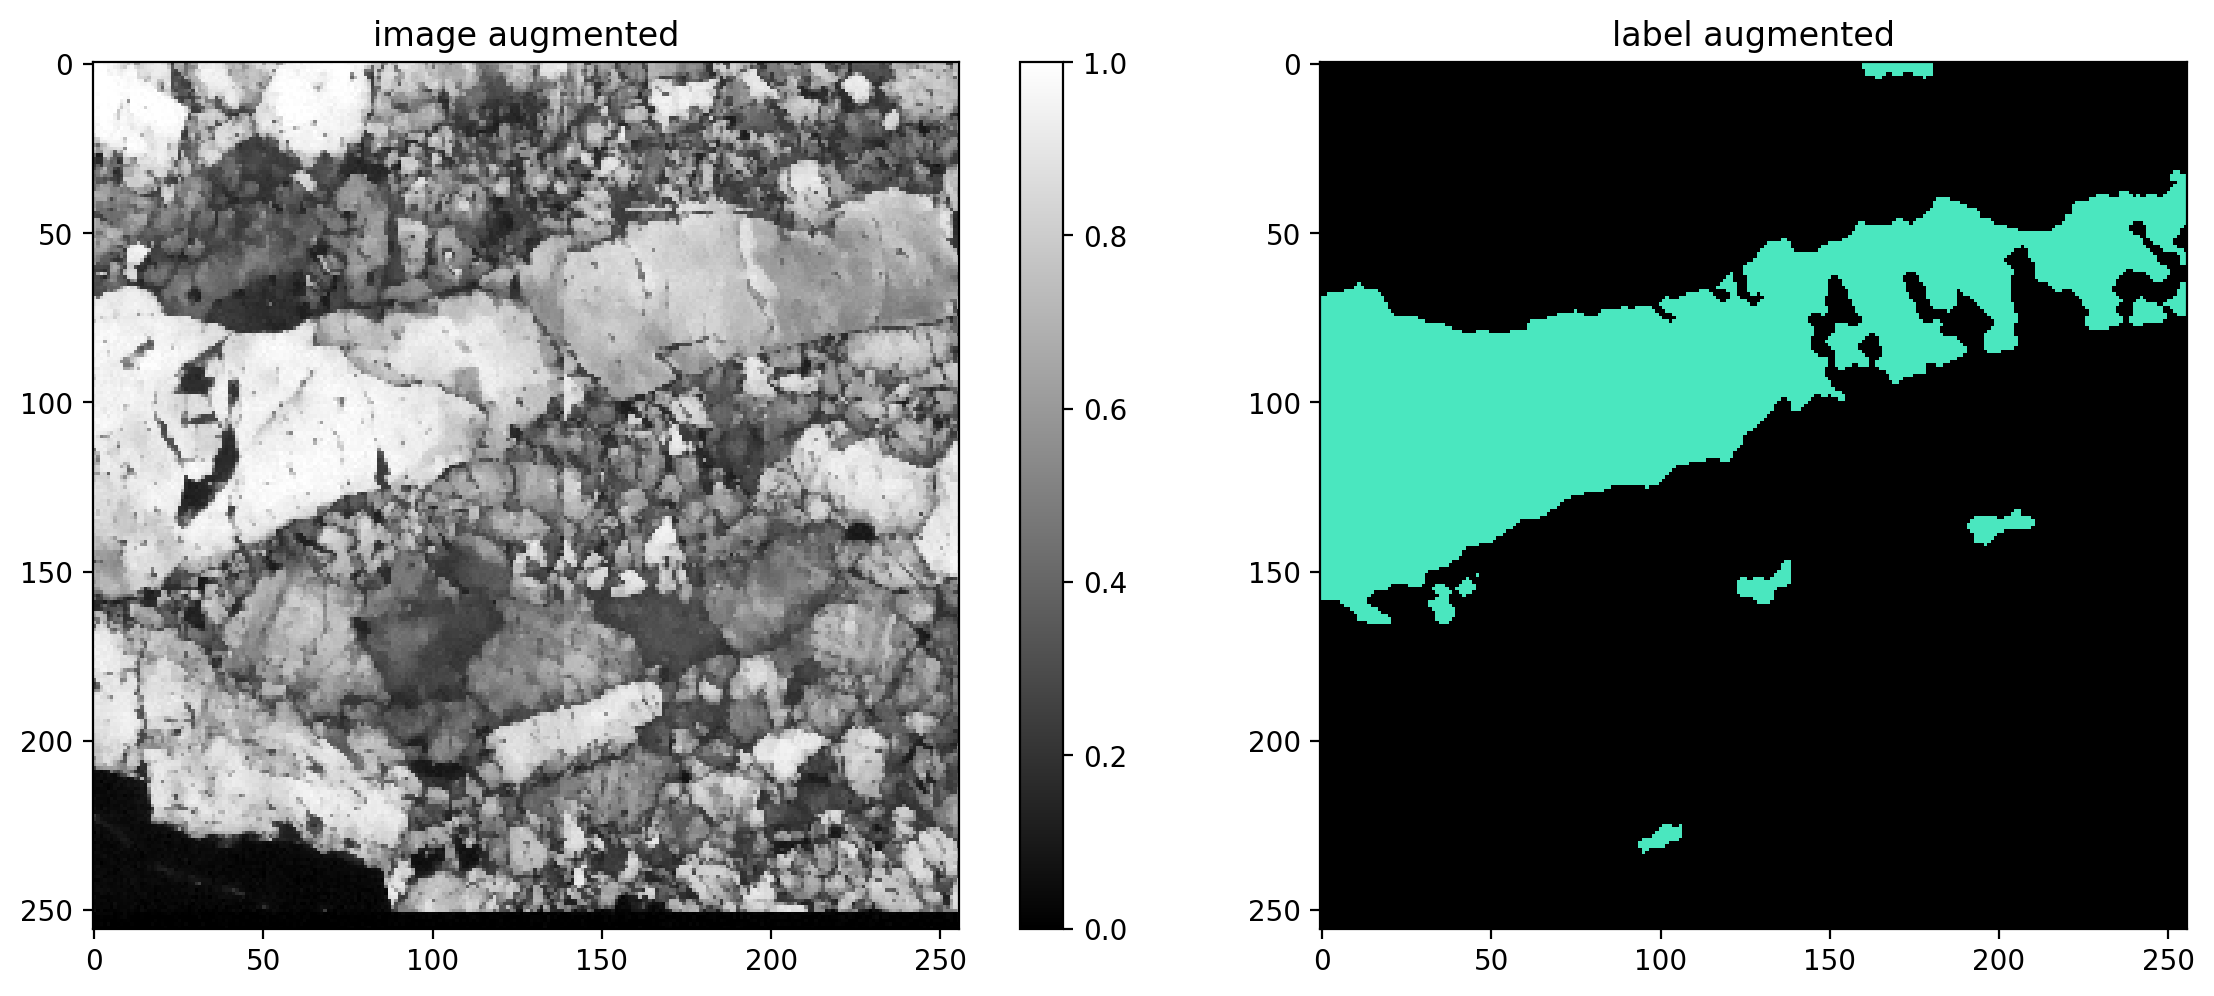

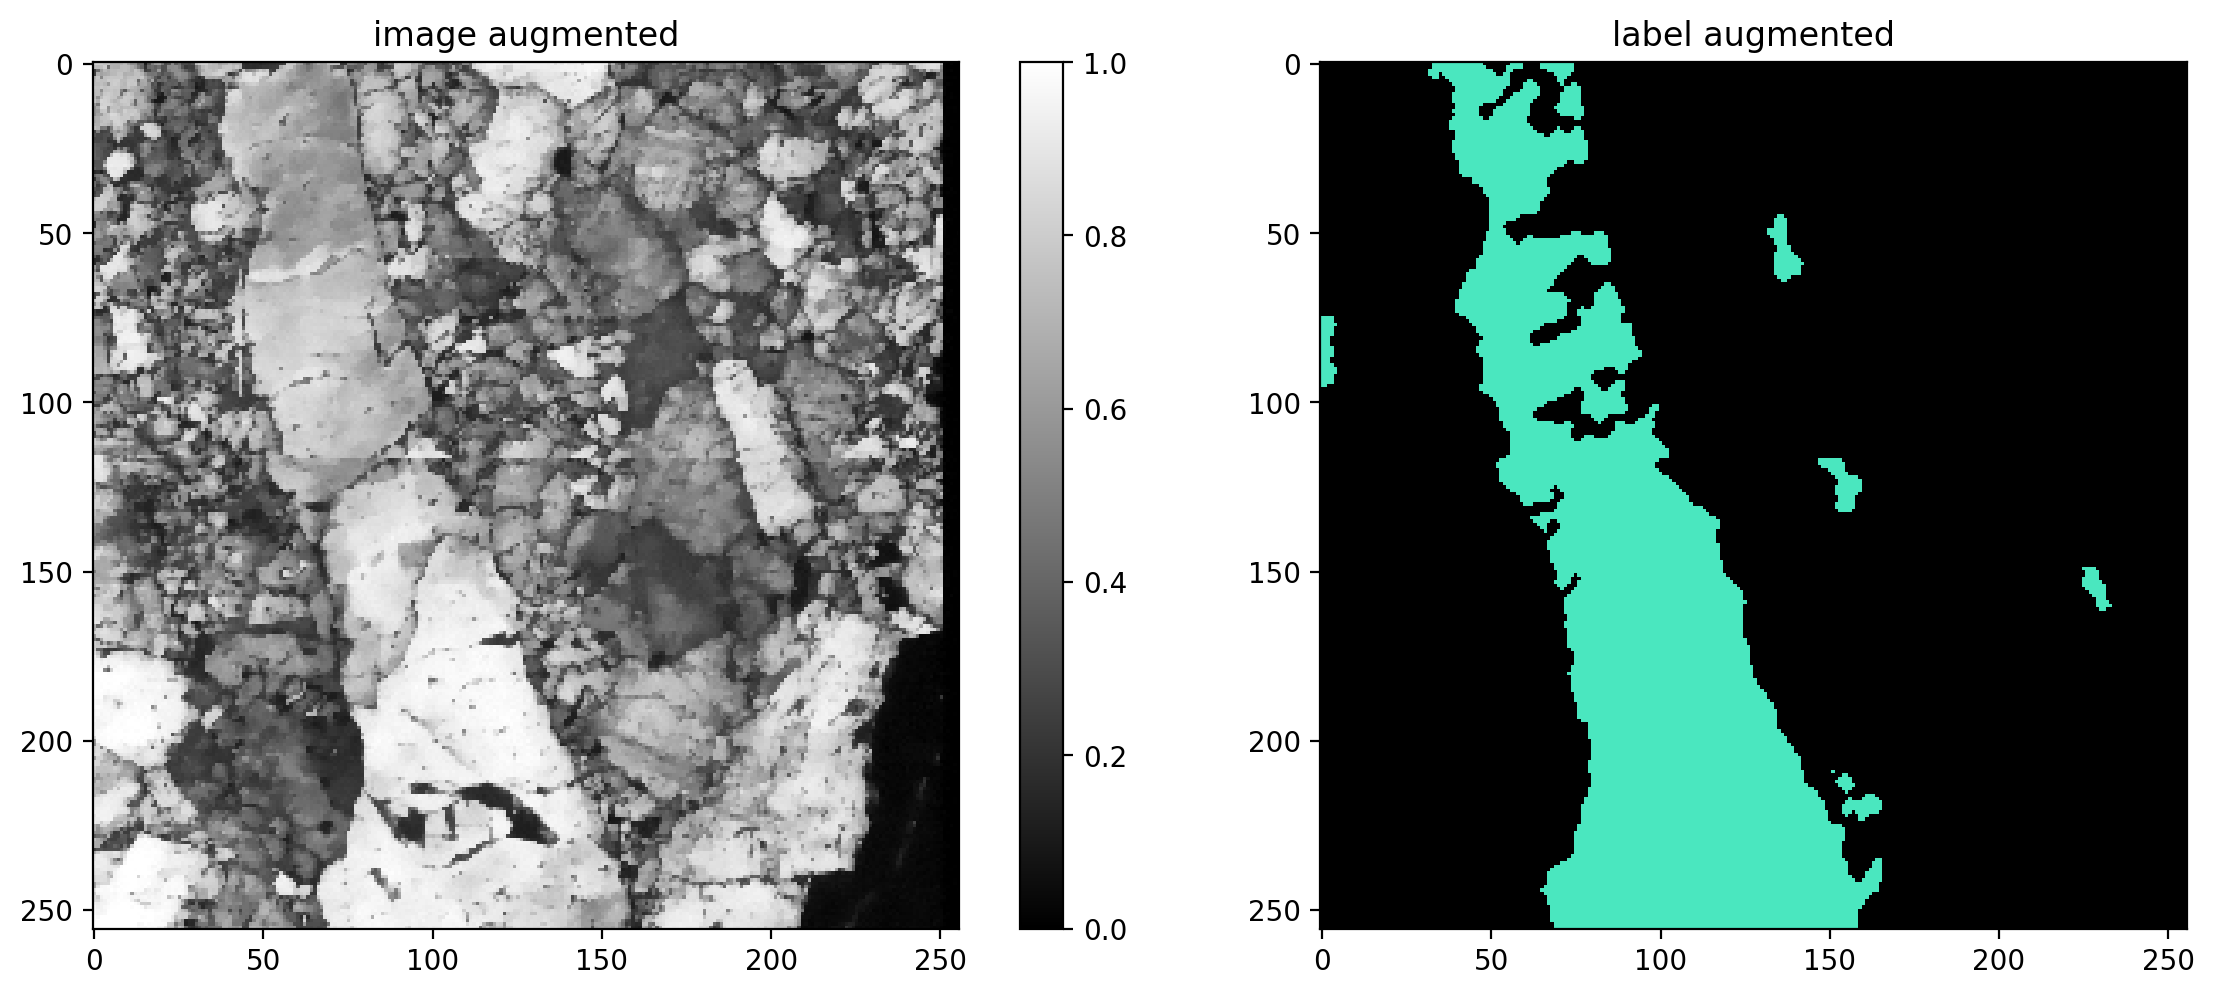

In [18]:
# plot some augmented examples
img, lbl = X[5],Y[5]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Model API
---
- Currently using the pretrained 2D_versatile_fluo model
- Freezing all layers except last 4 from training on new images


**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [19]:
# Loading pretrained model to display
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 1s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


**Check if the neural network has a large enough field of view to see up to the boundary of most objects.**

---

In [20]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [256. 200.]
network field of view :  [94 94]


In [21]:
# Access the underlying Keras model
new_model = model.keras_model

# Freeze all layers except the last 3
for layer in new_model.layers[:-3]:
    layer.trainable = False

# Display model summary
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, None, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       320       ['input[0][0]']               
                                                                                                  
 conv2d_1 (Conv2D)           (None, None, None, 32)       9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, None, None, 32)       0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Training

# Load pre-trained model (if applicable)

In [25]:
# Path where the model is saved
# model_path = '/content/drive/MyDrive/Grain Boundary Detection/Stardist'

# Load the saved model
# loaded_model = tf.keras.models.load_model(model_path)

In [26]:
# model = StarDist2D(None, name='trainedModel_126', basedir=model_path)

In [27]:
# quick_demo = False

# if quick_demo:
#     print (
#         "NOTE: This is only for a quick demonstration!\n"
#         "      Please set the variable 'quick_demo = False' for proper (long) training.",
#         file=sys.stderr, flush=True
#     )
#     model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
#                 epochs=2, steps_per_epoch=10)

#     print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
#     model = StarDist2D.from_pretrained('2D_demo')
# else:
#     model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=100, steps_per_epoch=10)
# None;

Recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


# Train Functional API model
---
- Default Params on model:
  - epochs: 400
  - steps per epoch: 100
  -


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create Tensorflow checkpoint object

# we will store the model in the following subdirectory within the current working directory.
checkpoint_path = '/content/drive/MyDrive/Grain Boundary Detection/Stardist/model_126'
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_weights_only=False,
                             save_freq='epoch',

                             verbose=1)

In [29]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=1000, steps_per_epoch=100)

Epoch 1/1000


Cause: Unable to locate the source code of <function _gcd_import at 0x7fc066793400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7fc066793400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 14s 65ms/step - loss: 4.2072 - prob_loss: 0.1963 - dist_loss: 20.0545 - prob_kld: 0.1201 - dist_relevant_mae: 20.0529 - dist_relevant_mse: 1322.0576 - dist_dist_iou_metric: 0.3162 - val_loss: 3.5555 - val_prob_loss: 0.1254 - val_dist_loss: 17.1505 - val_prob_kld: 0.0811 - val_dist_relevant_mae: 17.1489 - val_dist_relevant_mse: 889.3036 - val_dist_dist_iou_metric: 0.3551 - lr: 3.0000e-04
Epoch 2/1000
100/100 [=========================

# Threshold optimization

In [30]:
quick_demo = False

if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:00<00:00, 18.64it/s, 0.275 -> 0.056]


Using optimized values: prob_thresh=0.273754, nms_thresh=0.3.


# Saving the model to be used later

In [31]:
# Save StarDist model object in this path

newpath = r'savedModel'
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Save the entire model in the native Keras format

model_path = os.path.join(os.getcwd(),newpath)
print(model_path)

model.keras_model.save(model_path)

/content/savedModel


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function).
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [32]:
# help(matching)

In [33]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 14/14 [00:01<00:00, 10.48it/s]


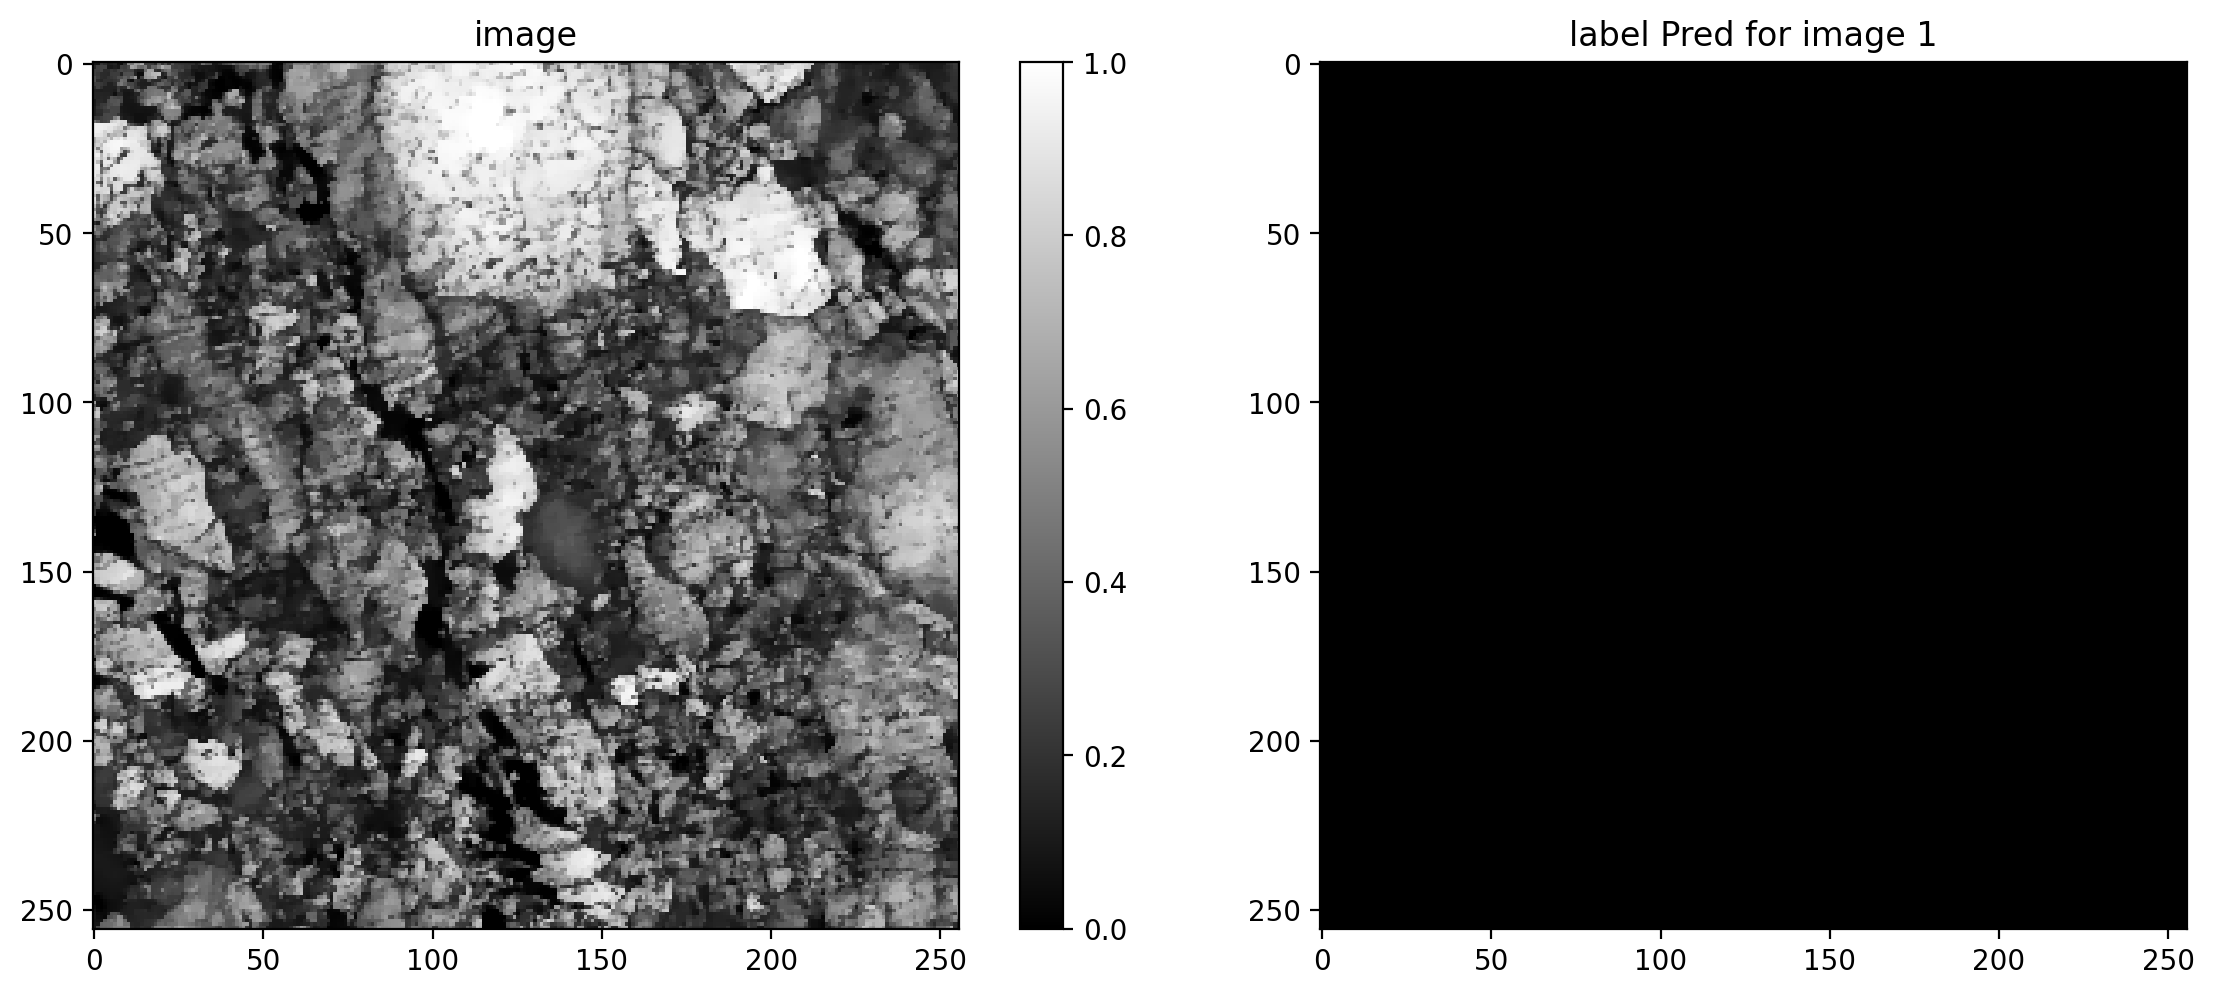

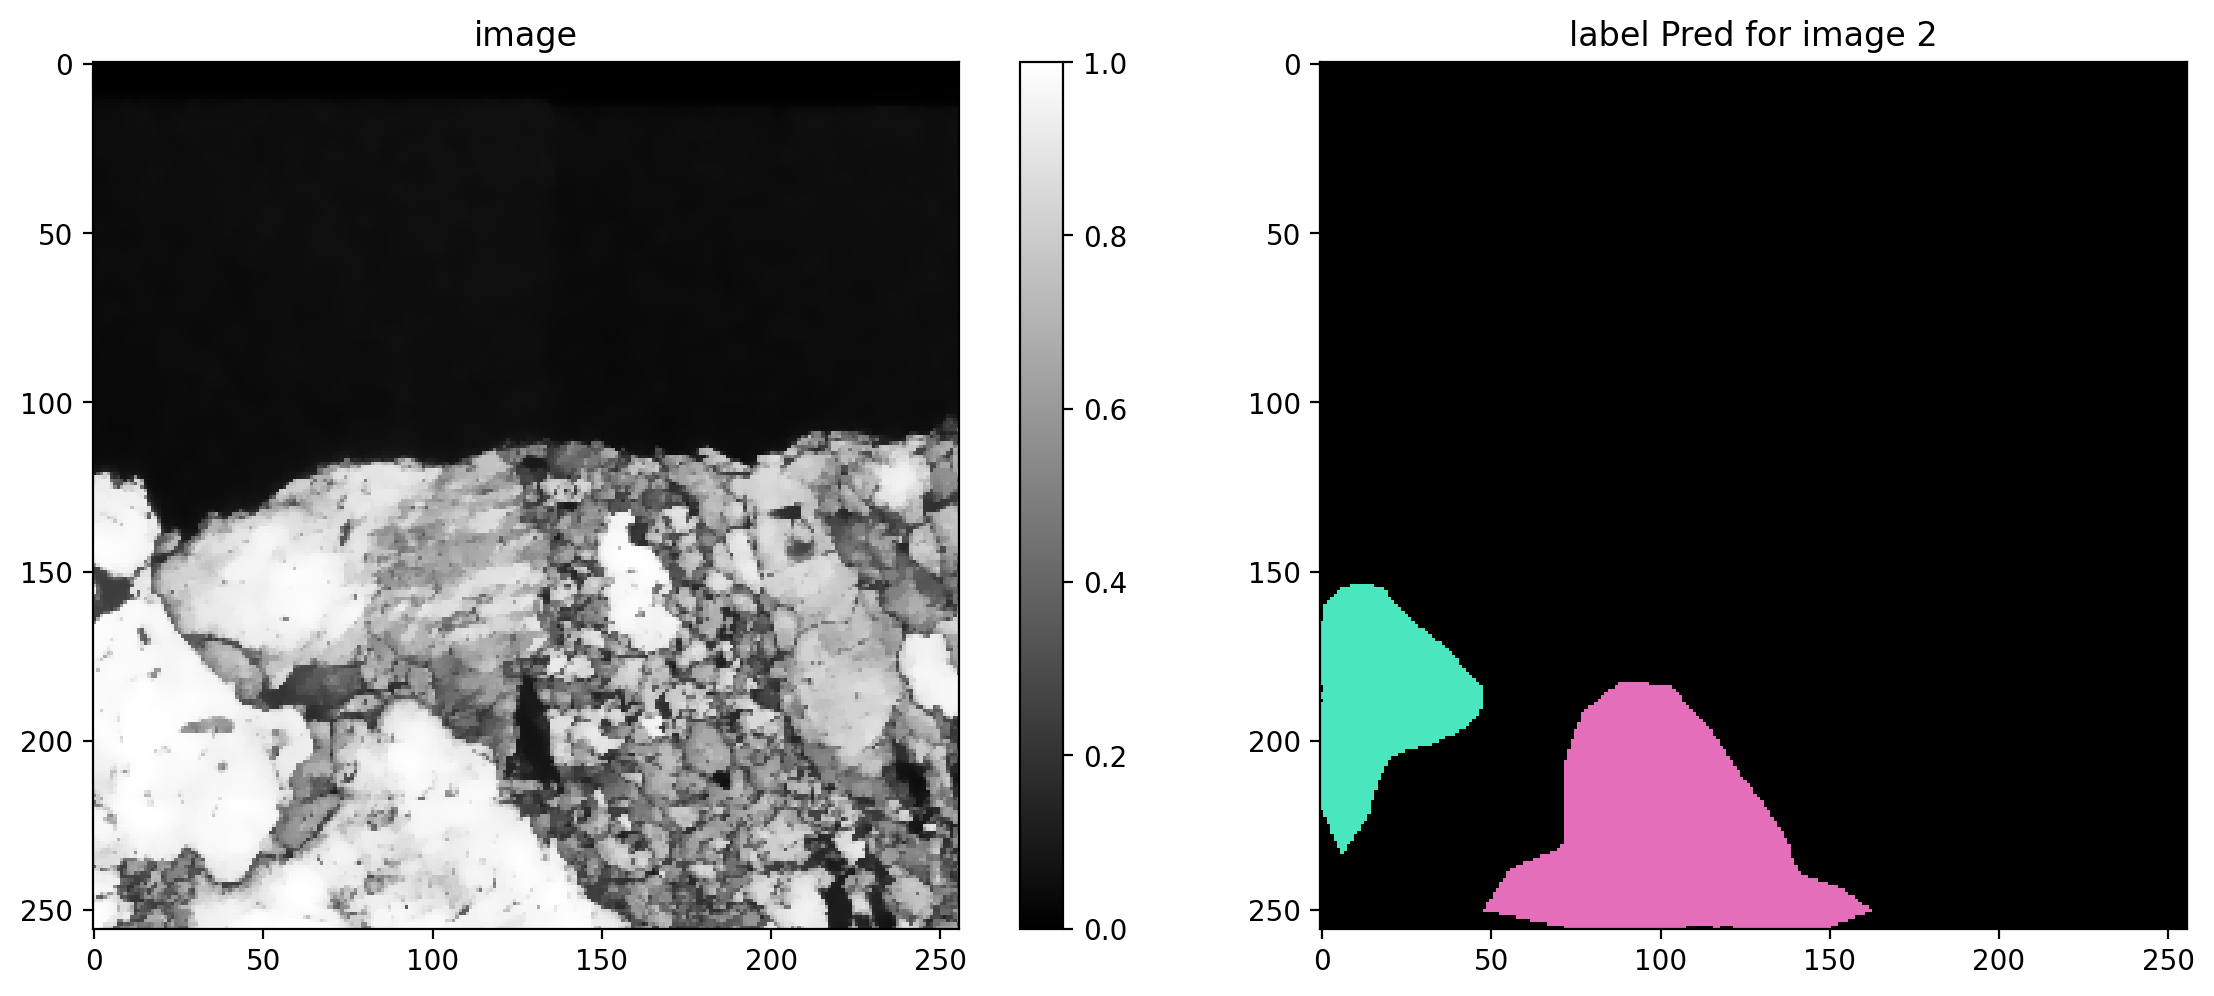

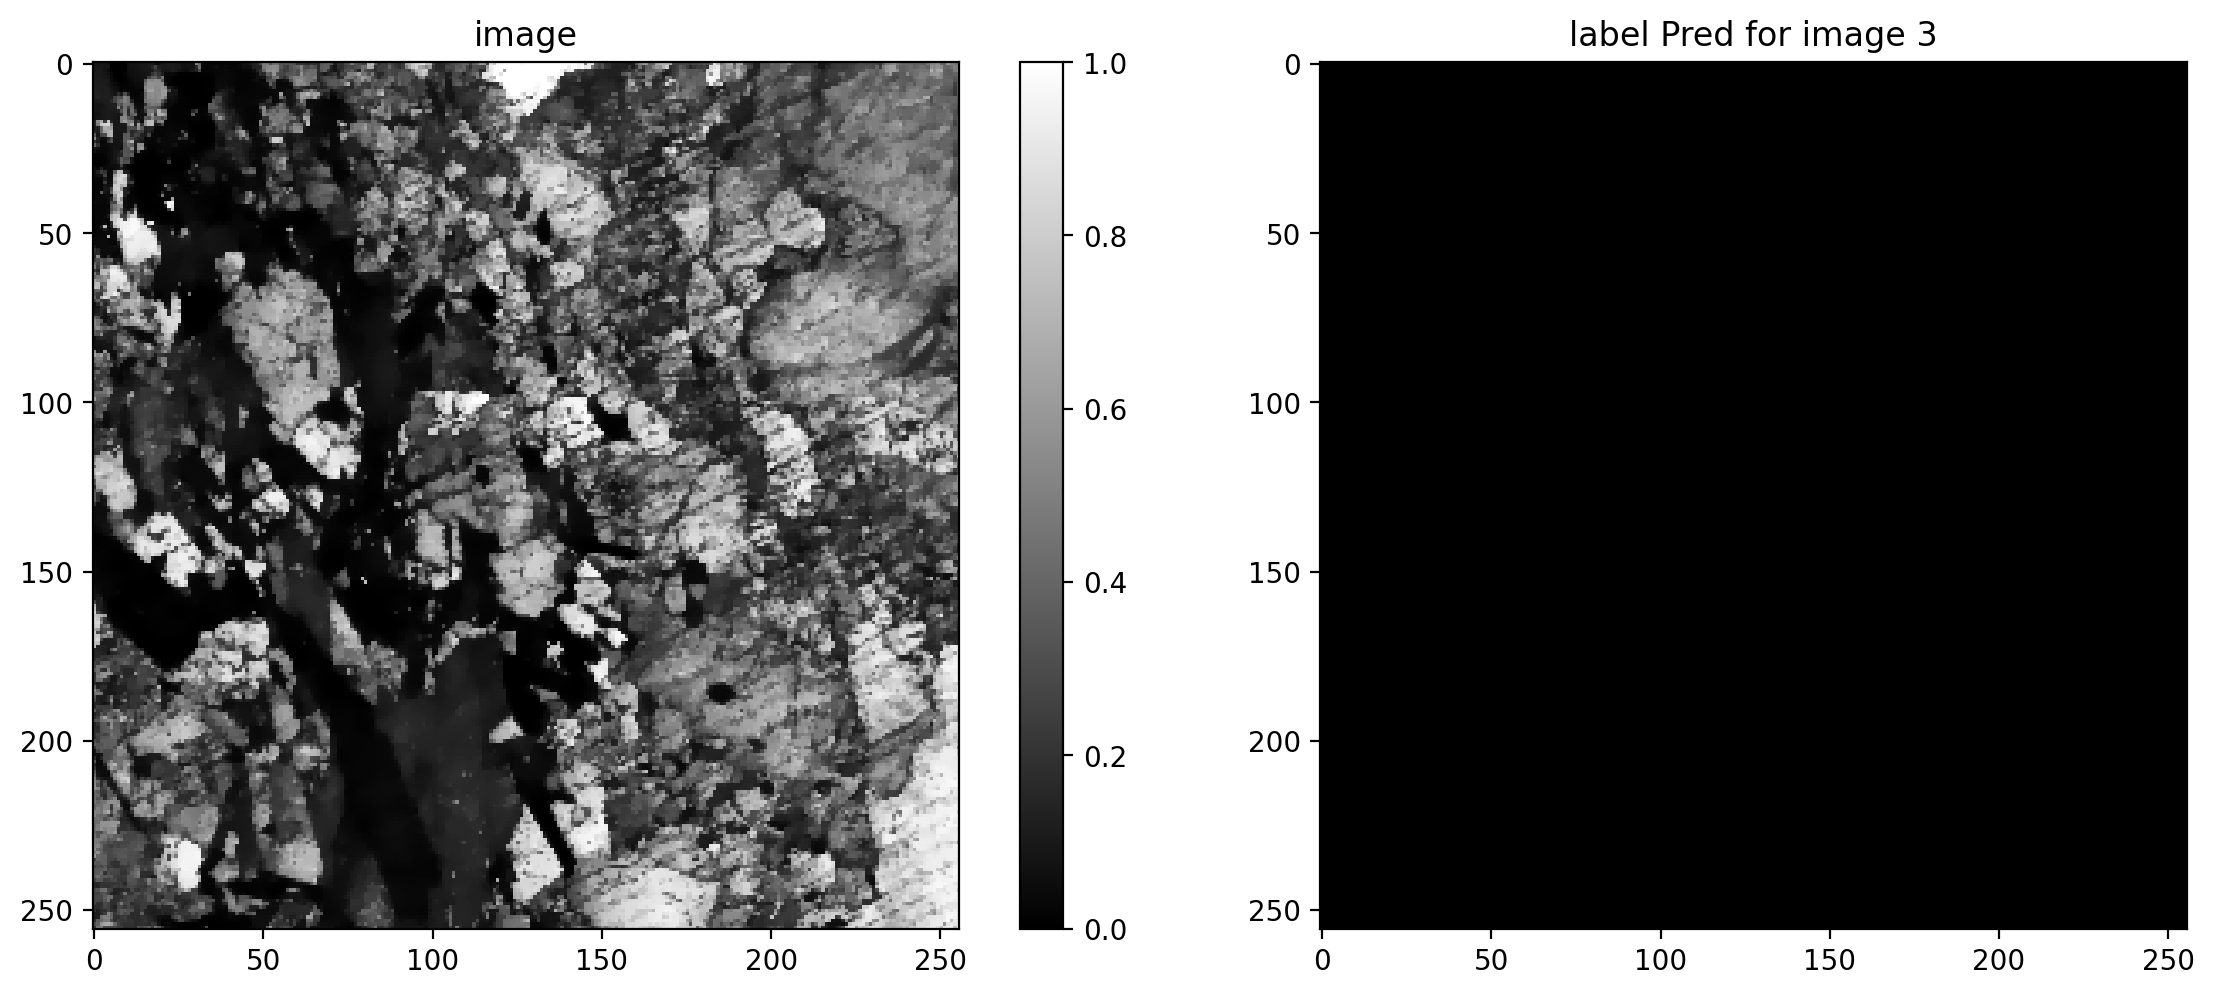

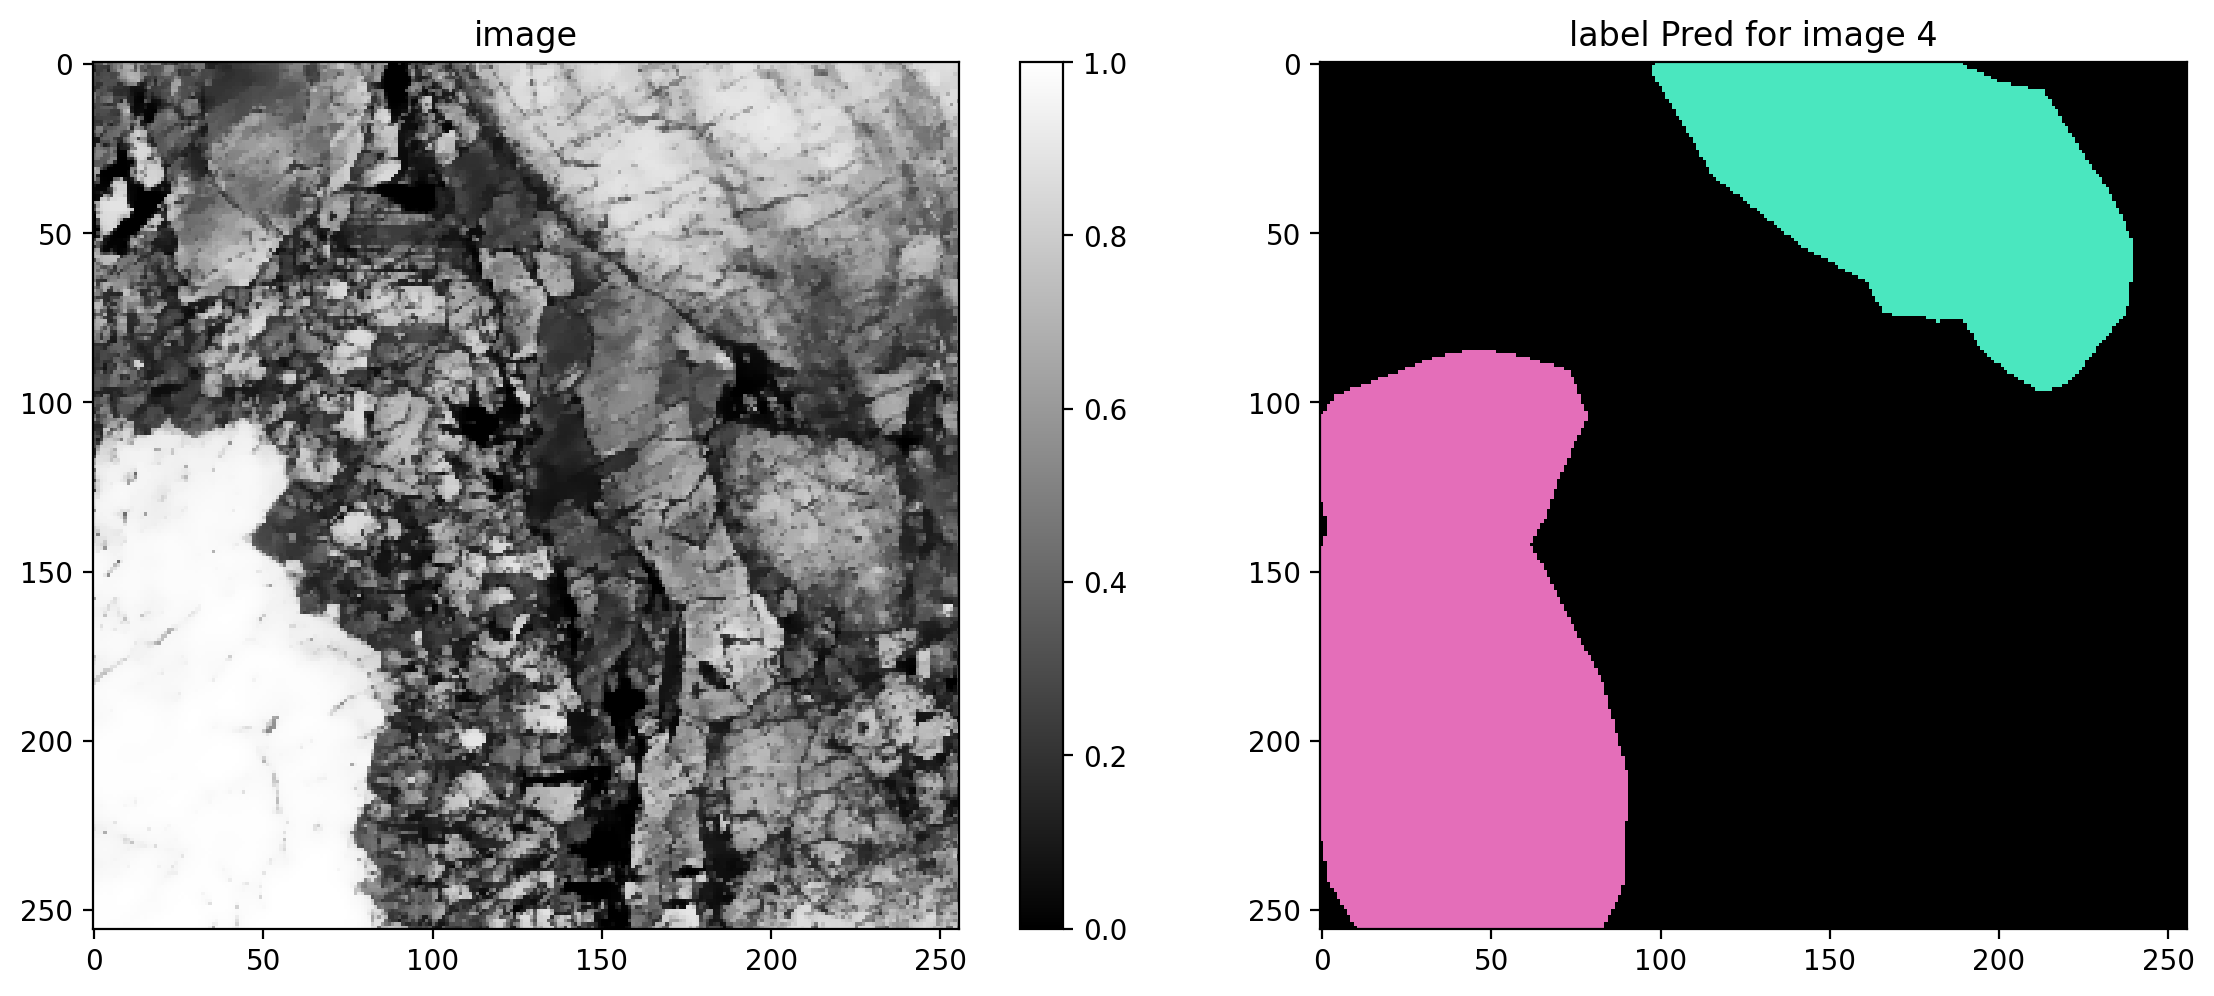

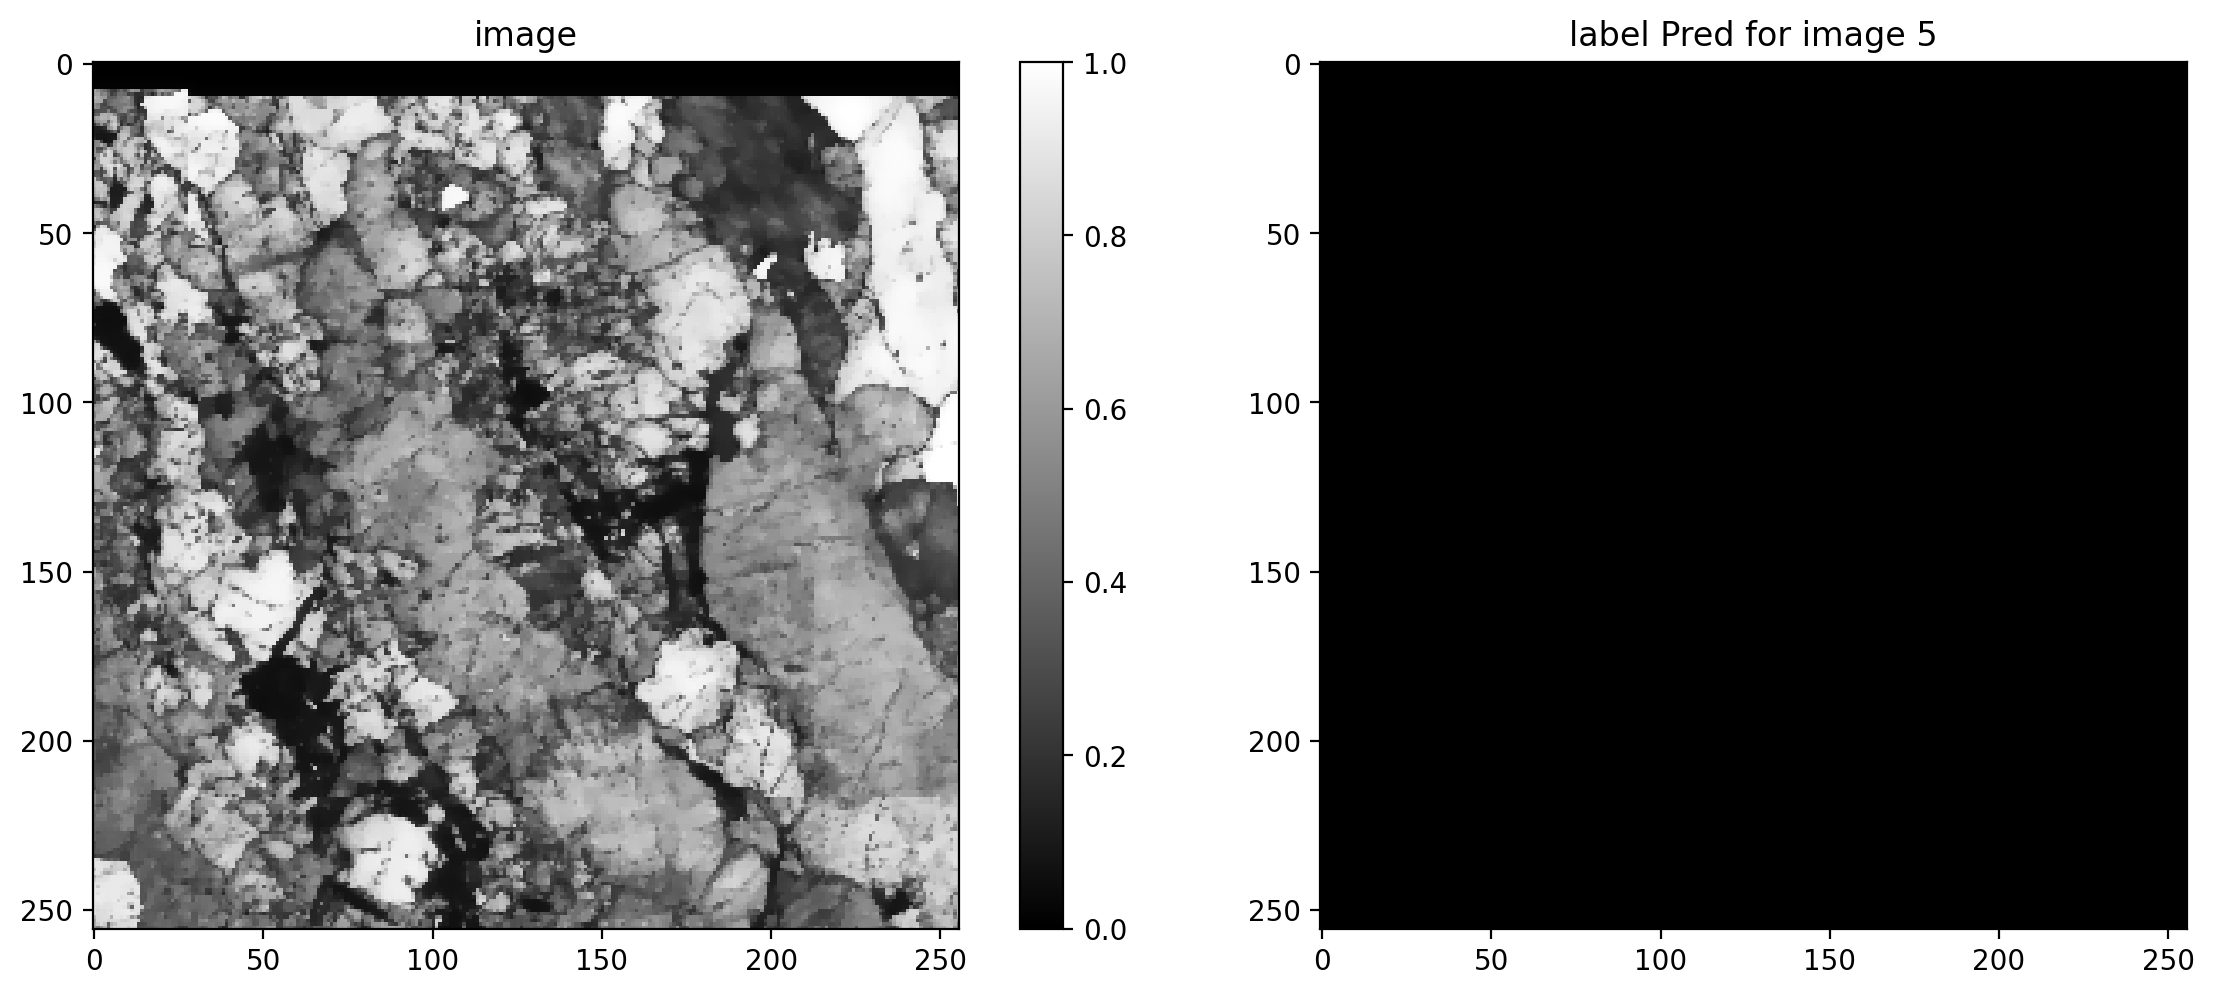

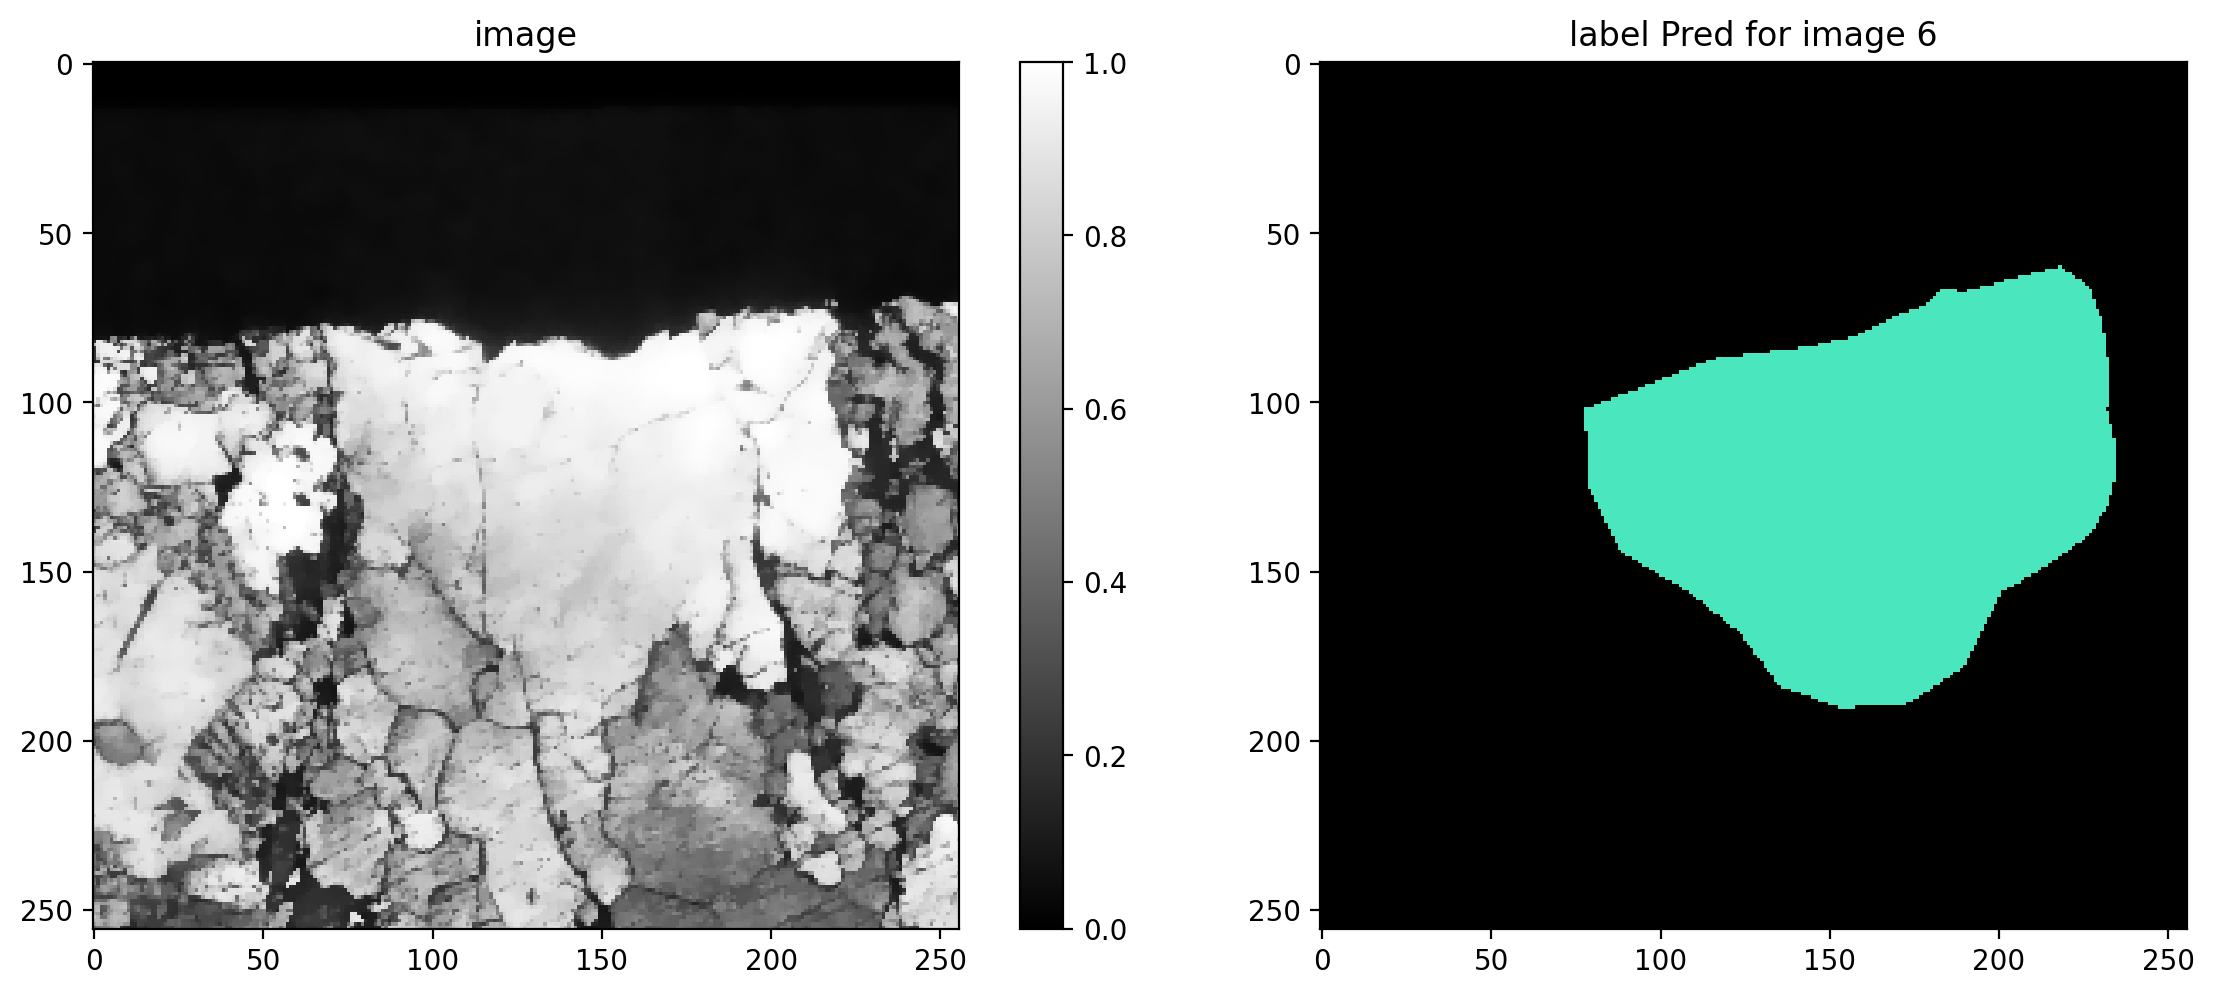

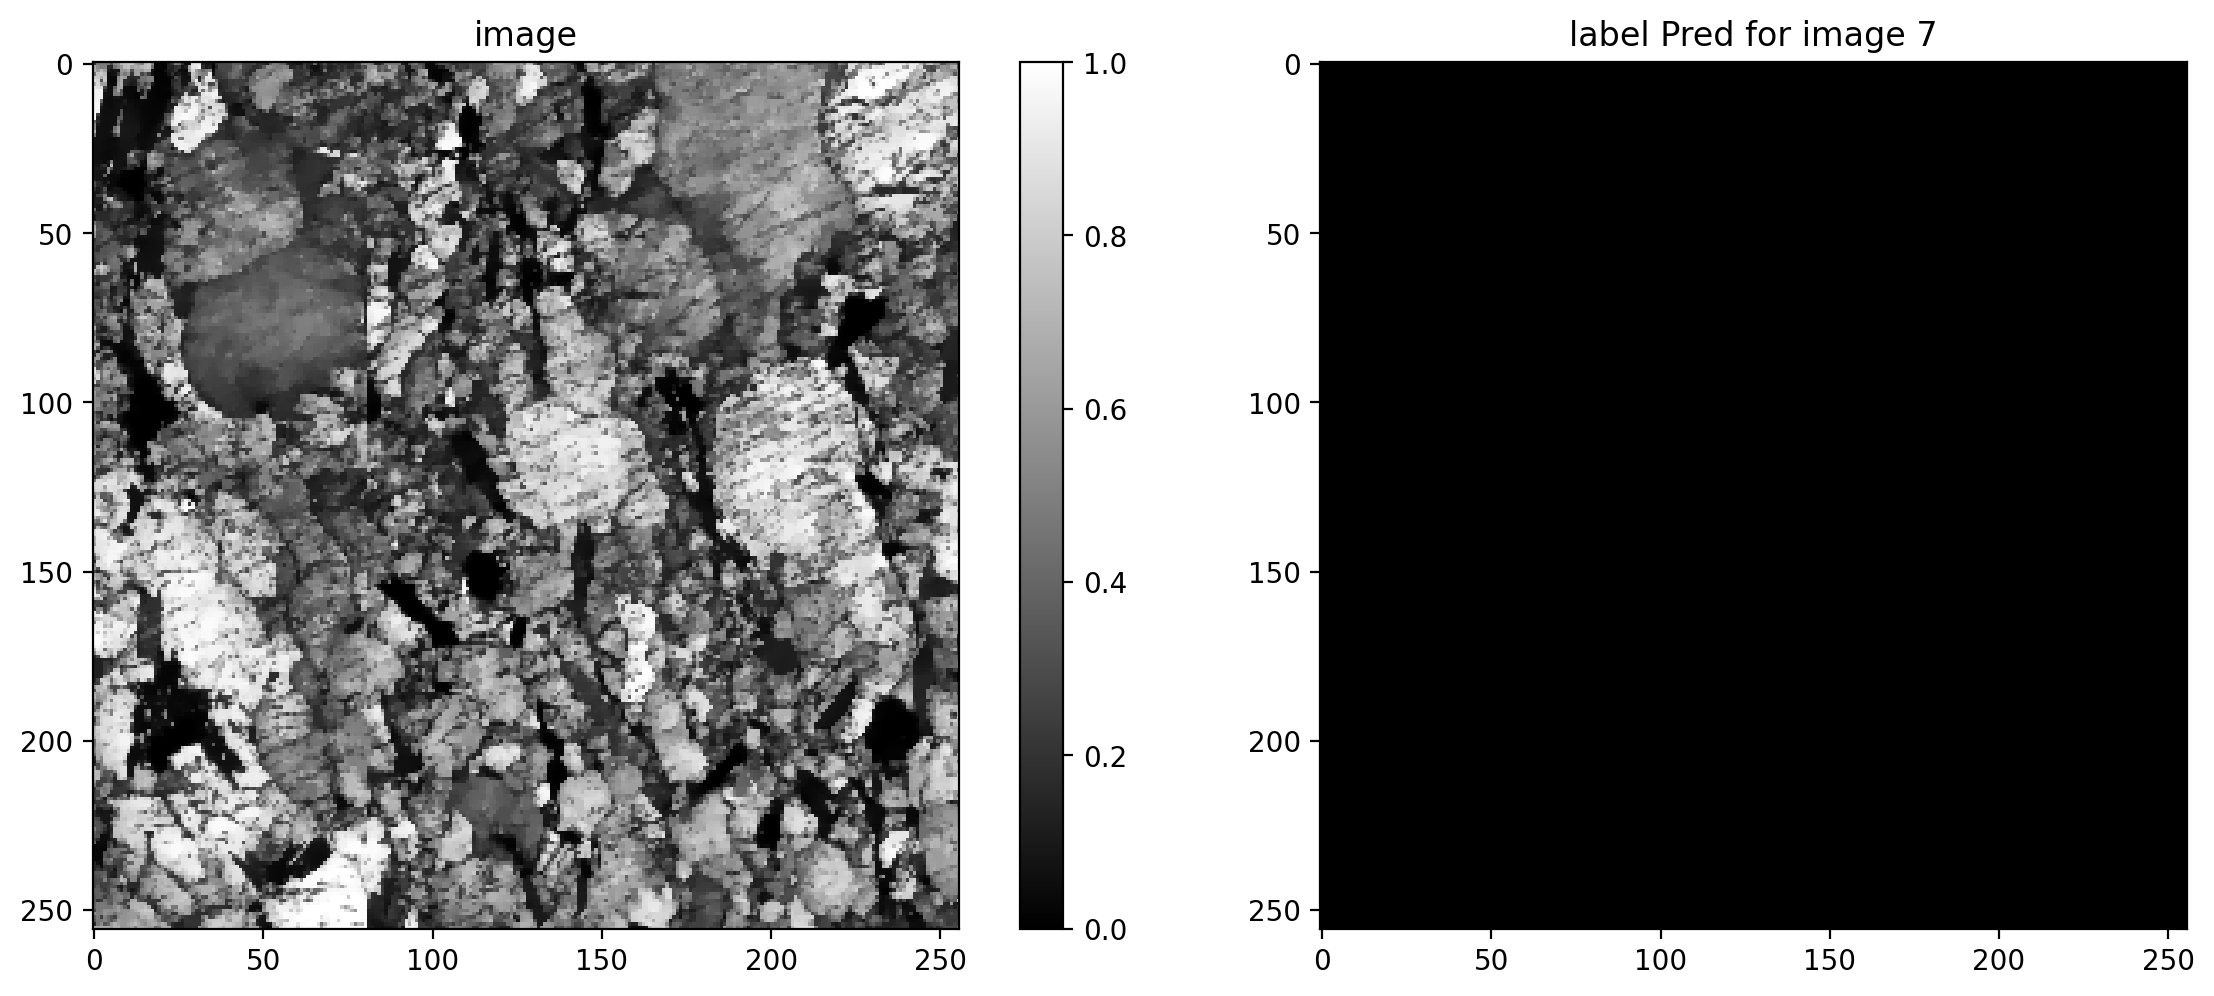

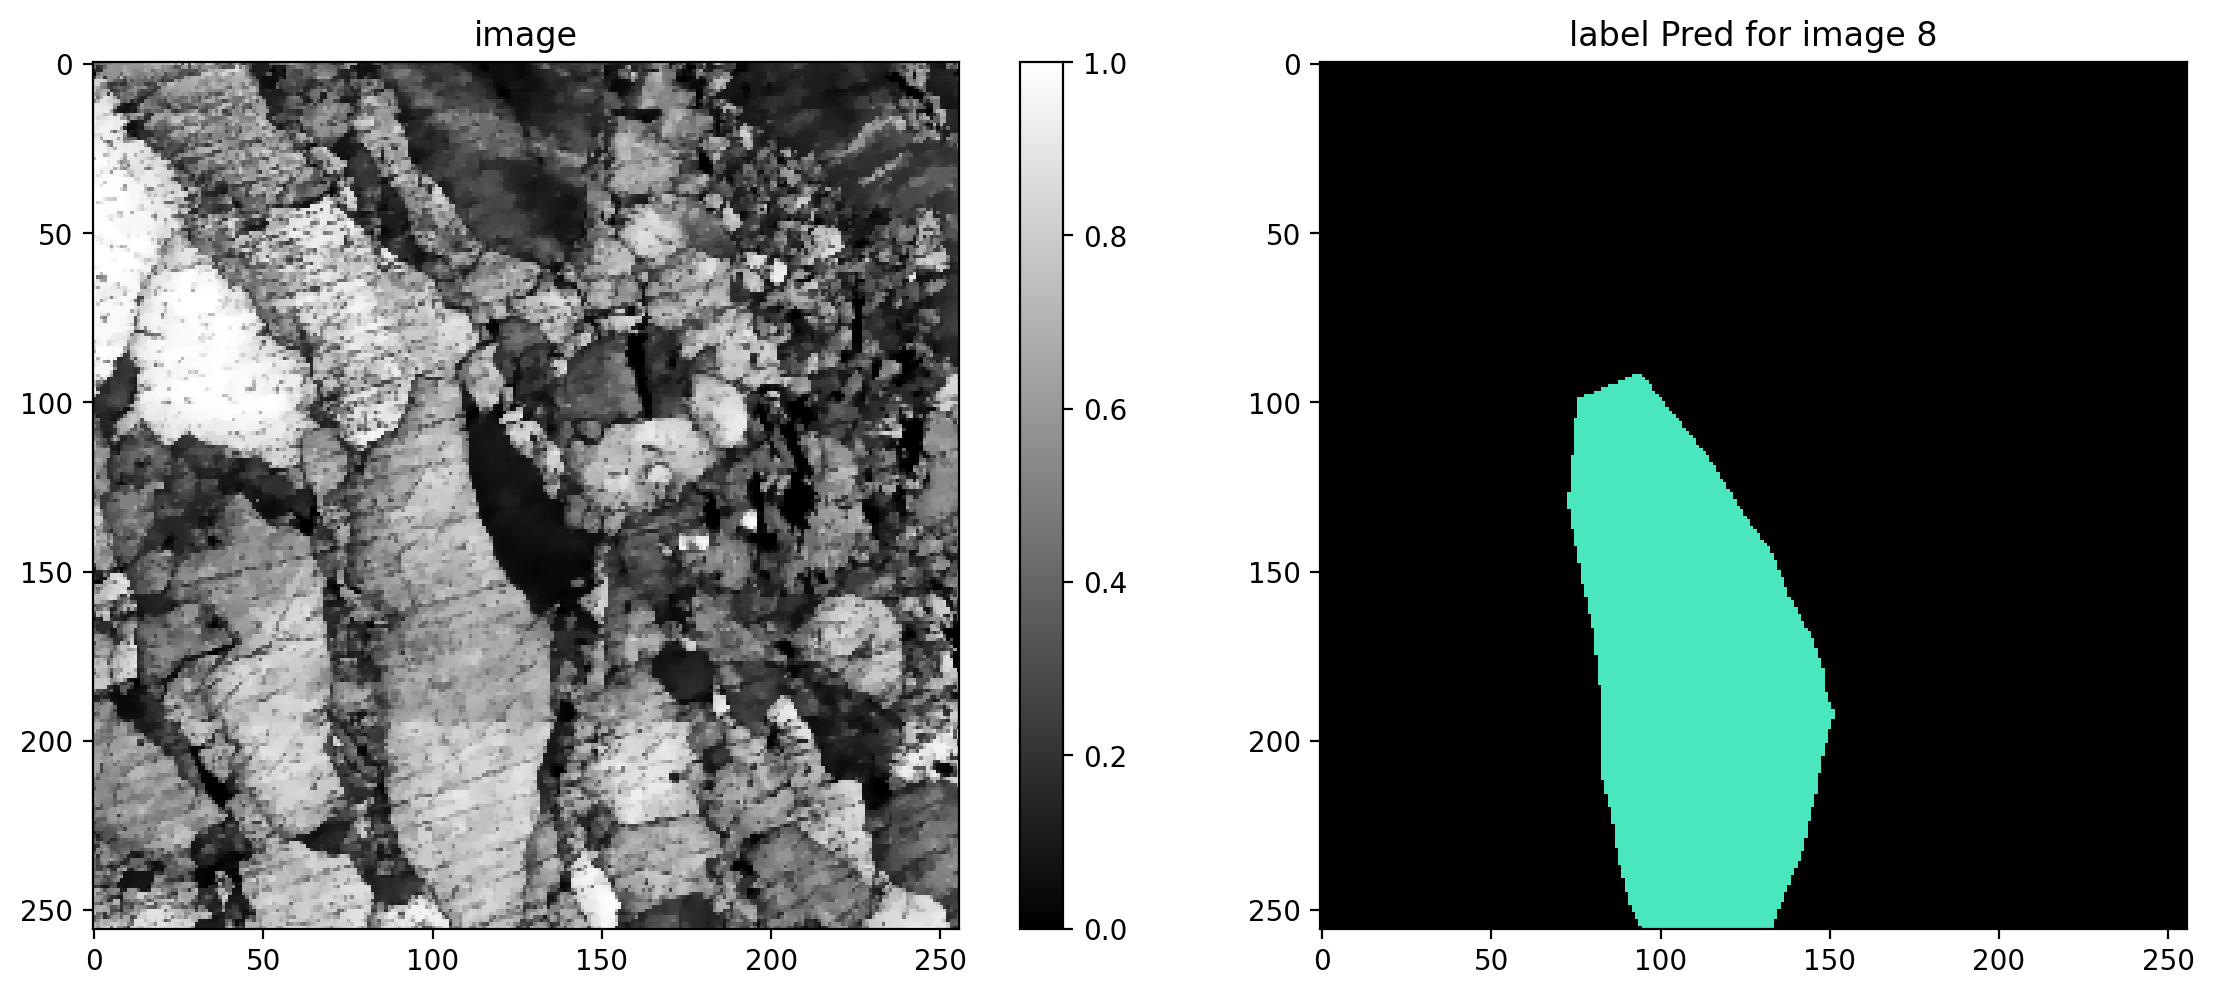

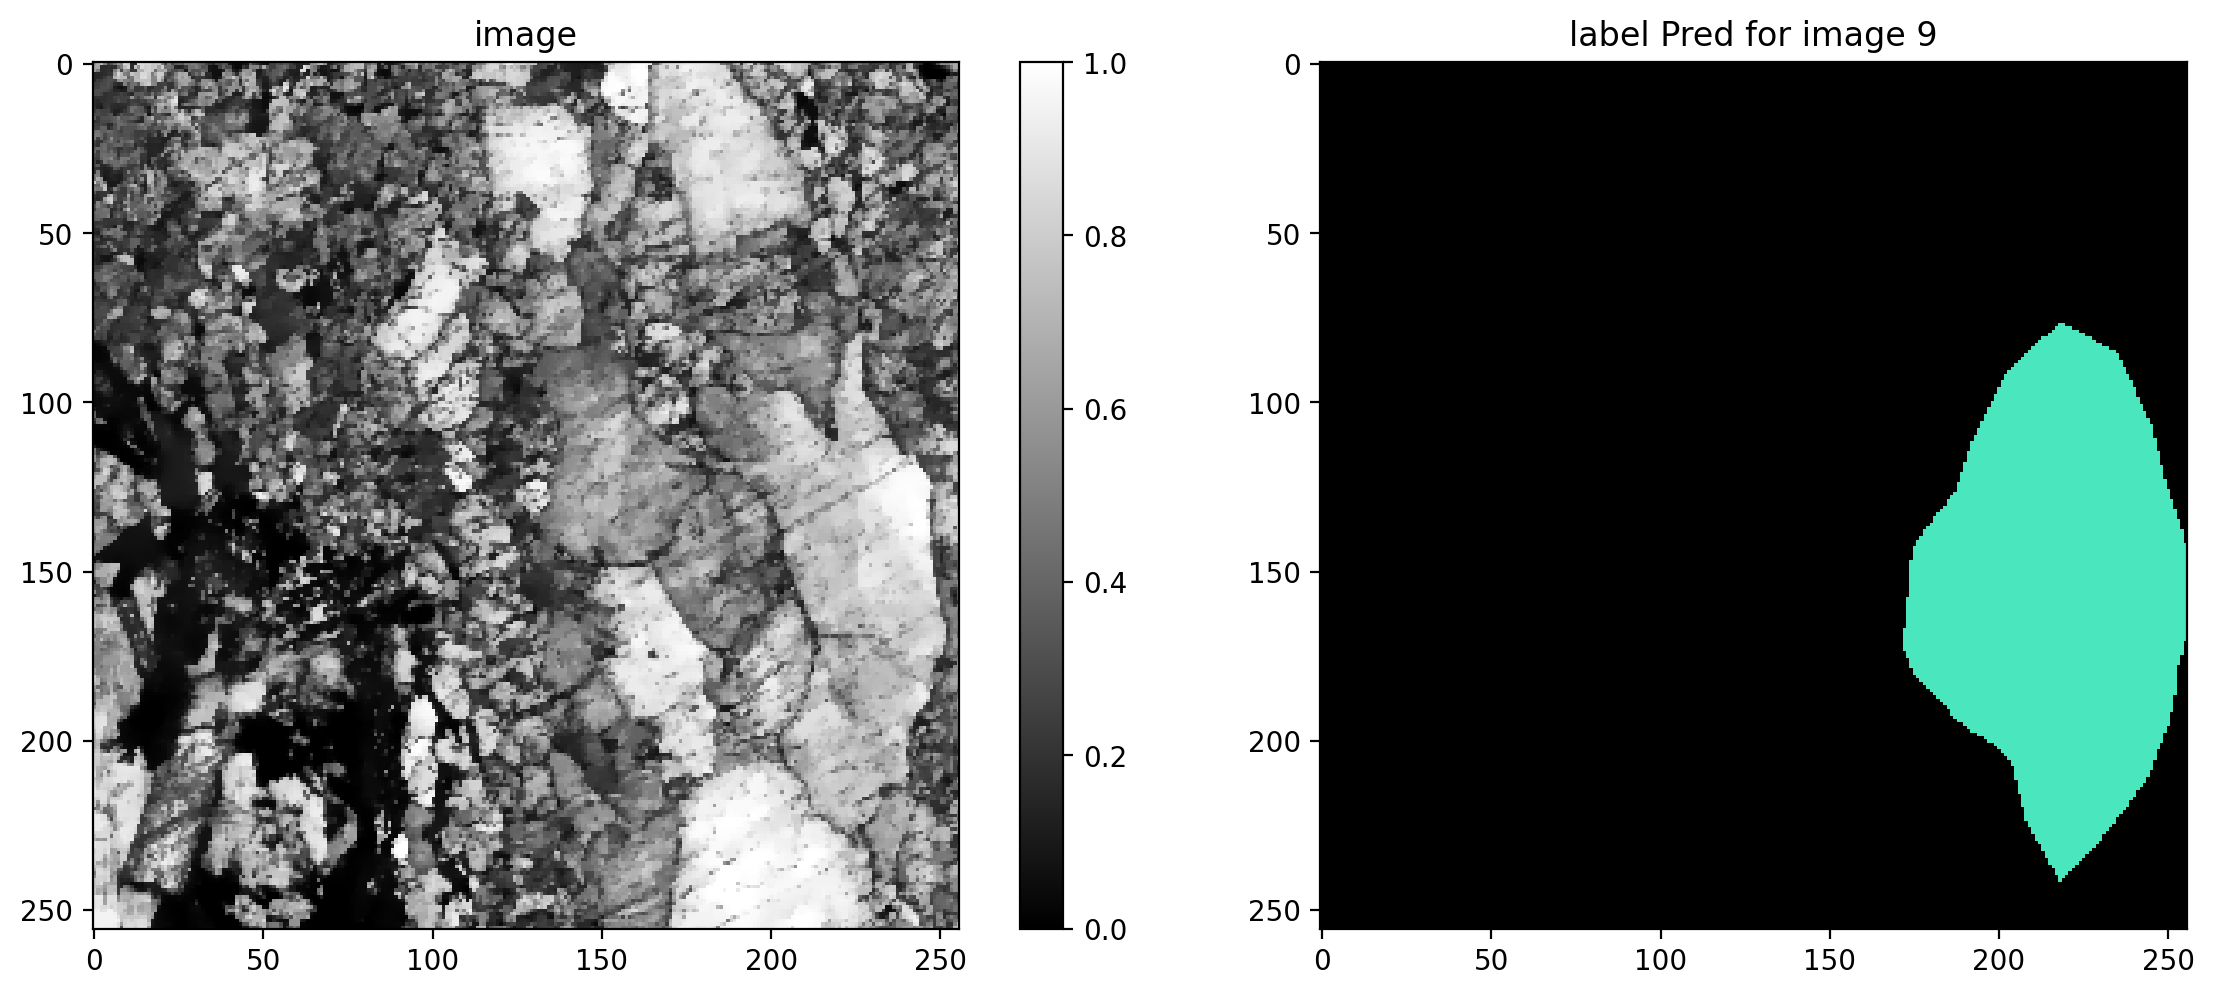

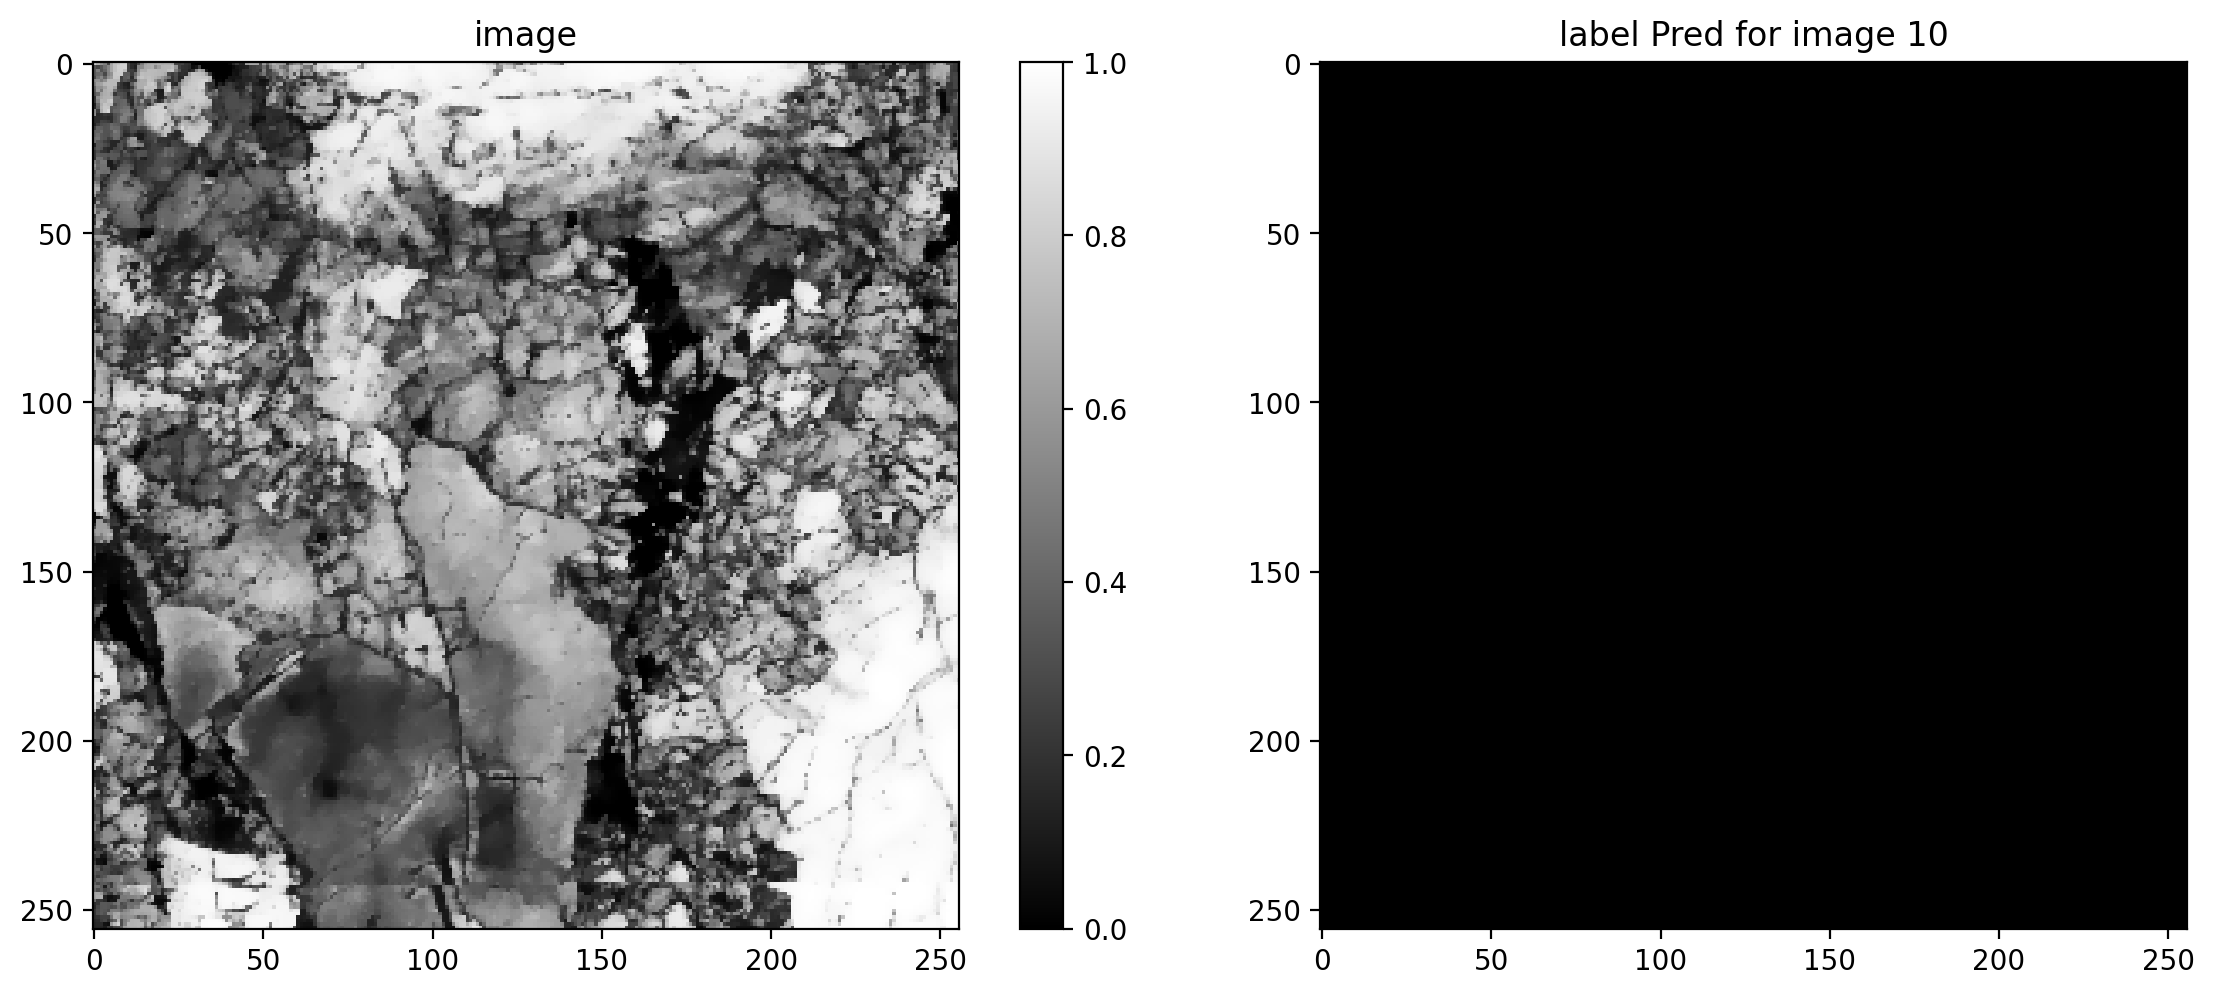

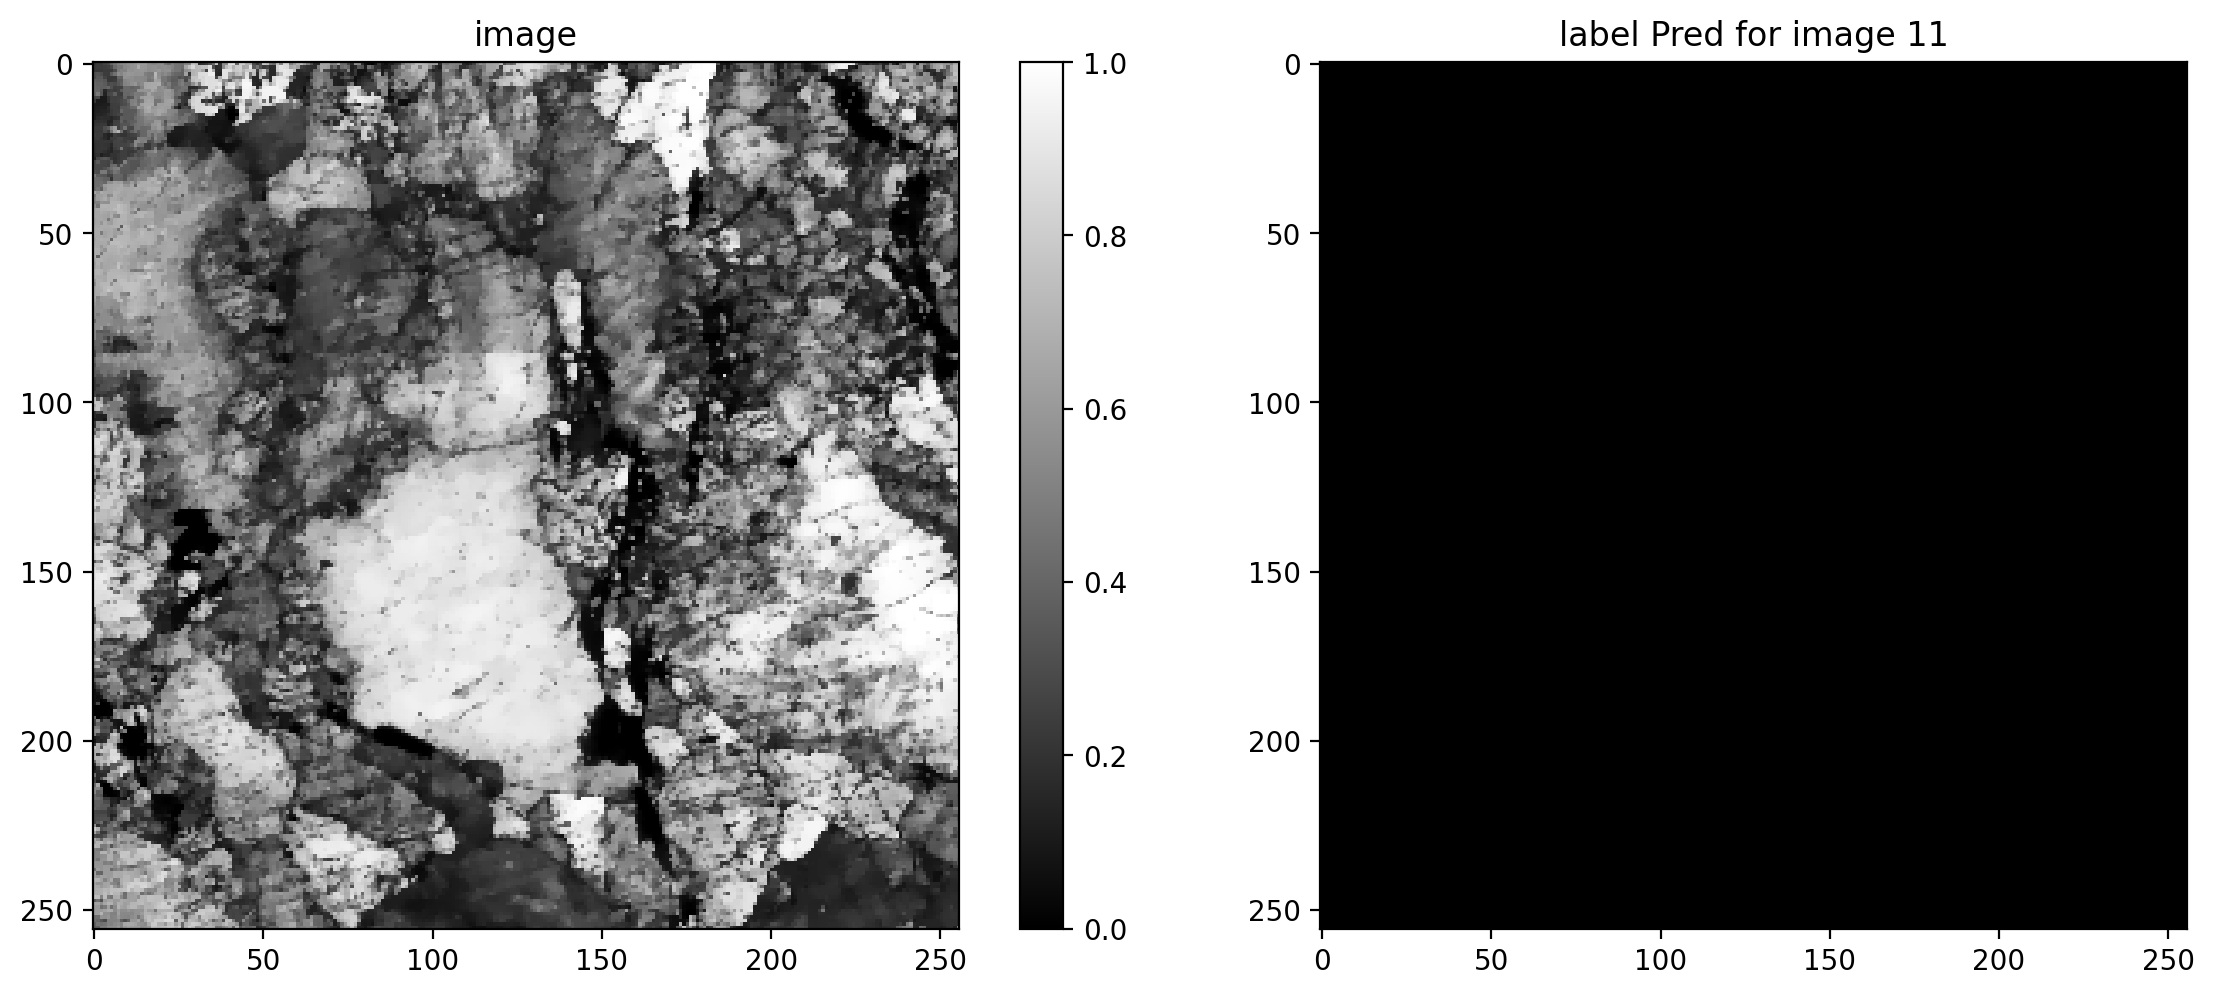

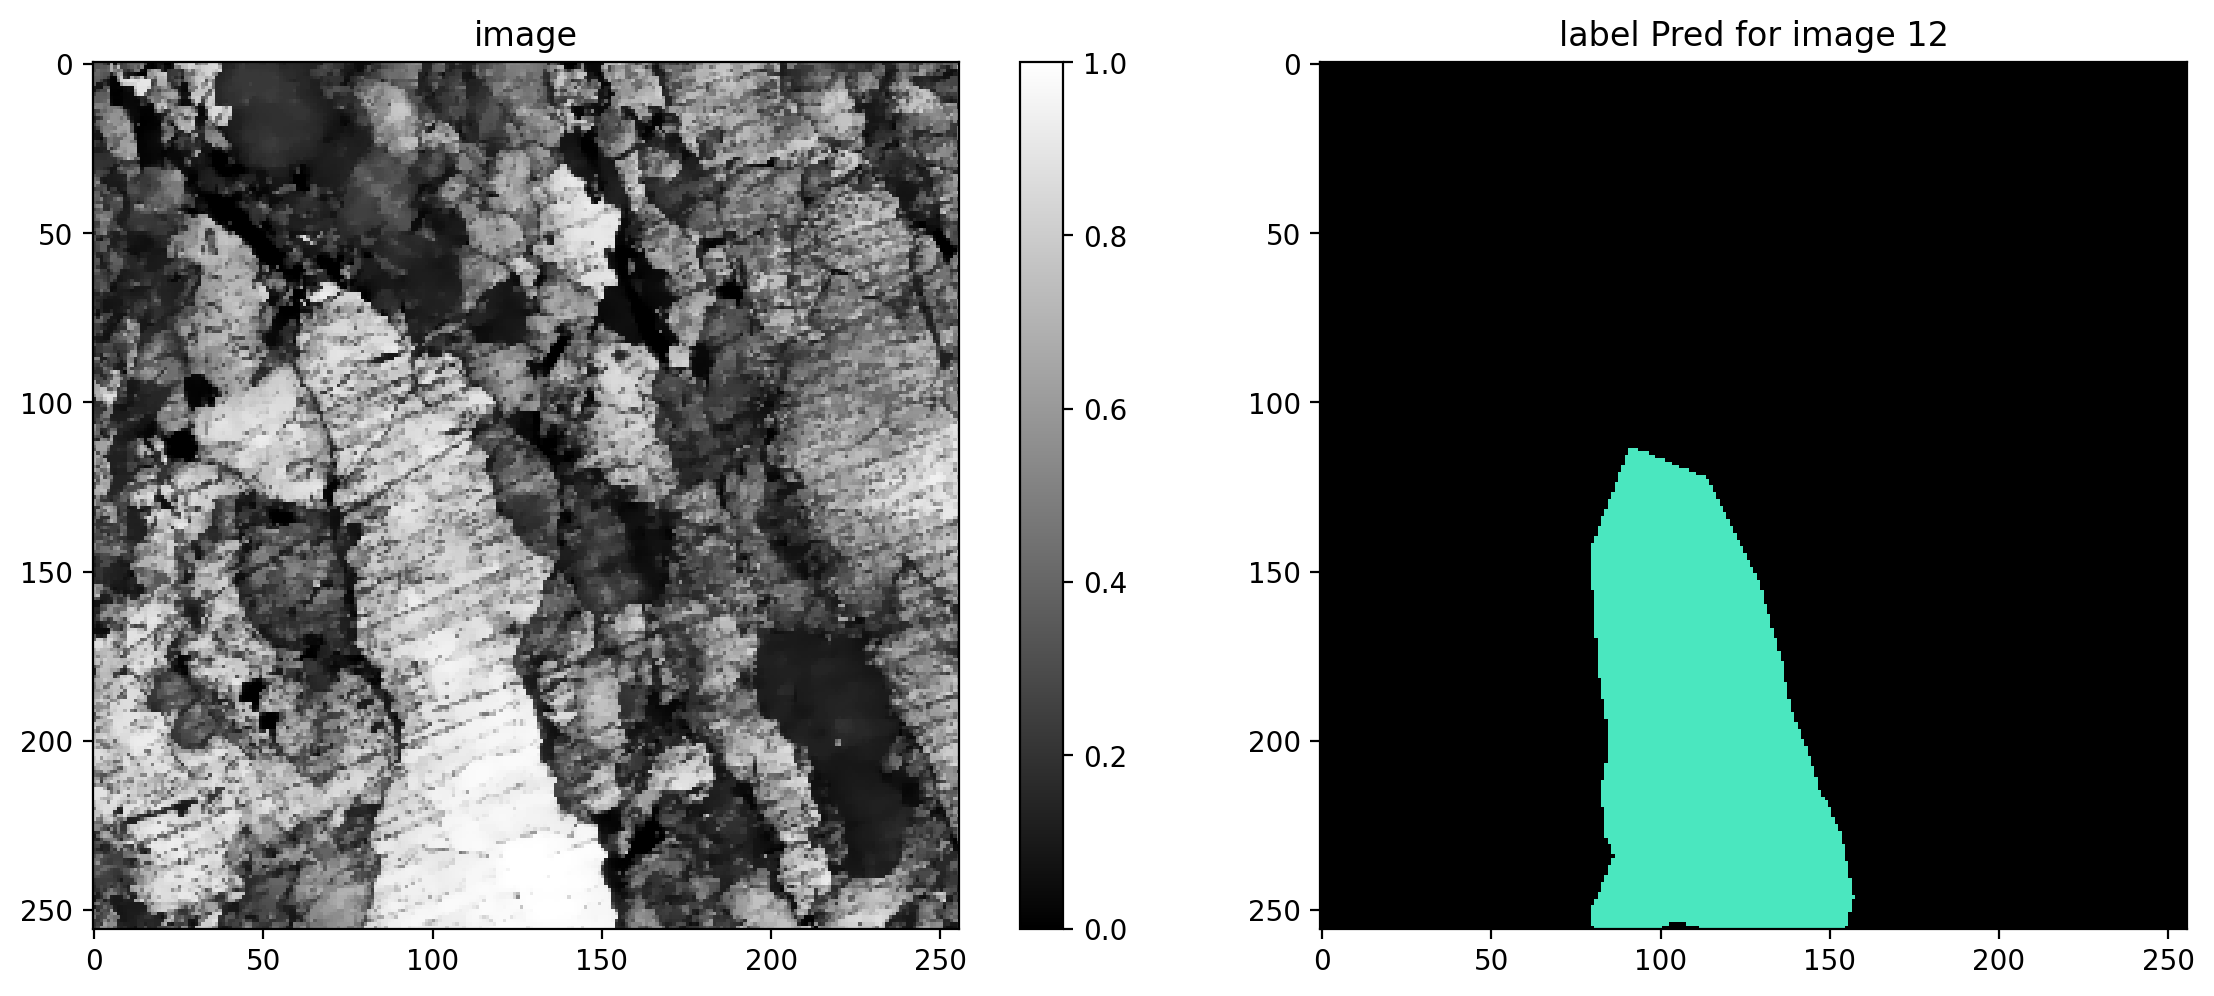

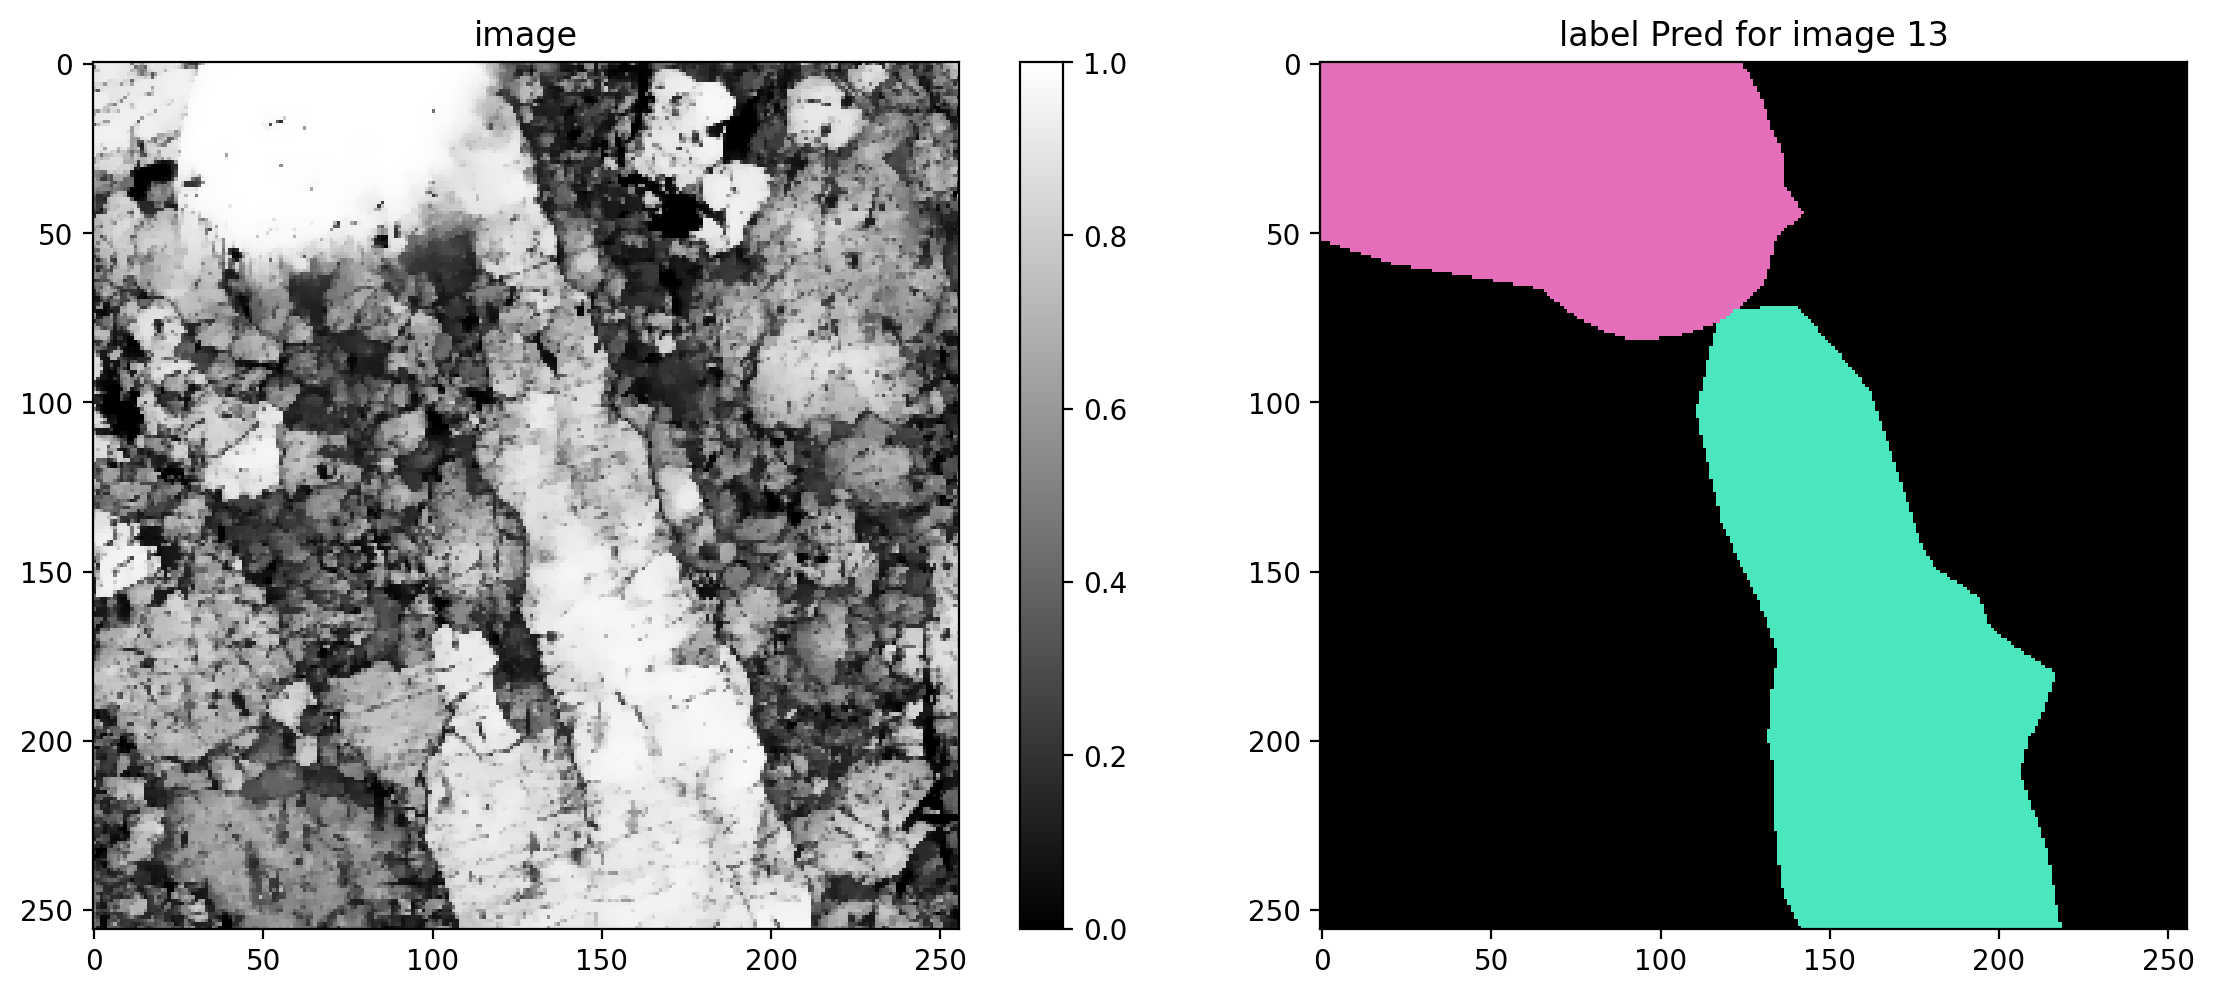

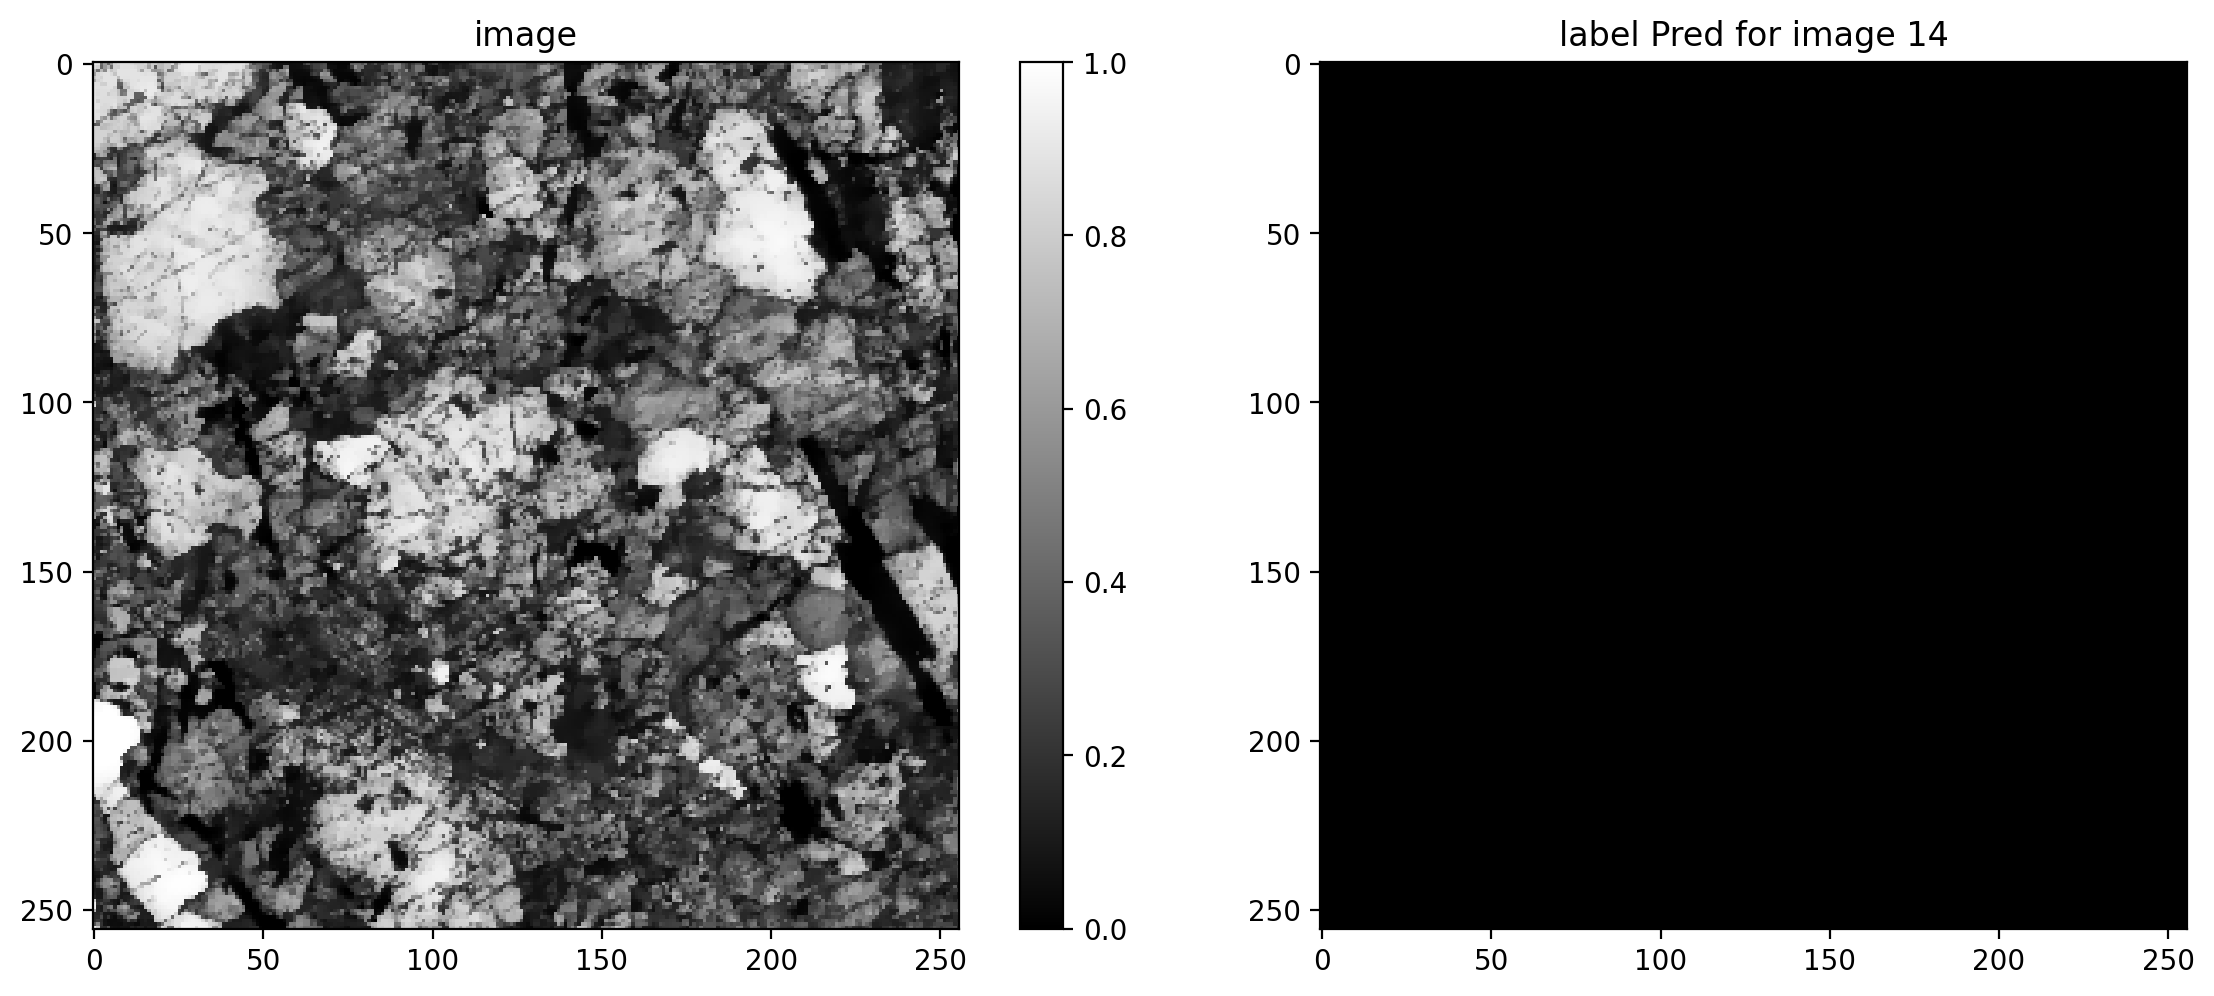

In [34]:
for i in range(14):
    # plot_img_label(X_val[i], Y_val[i], lbl_title=f"label GT for image {i+1}")
    plot_img_label(X_val[i], Y_val_pred[i], lbl_title=f"label Pred for image {i+1}")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:00<00:00, 39.83it/s]


Example: Print all available matching statistics for $\tau=0.5$

In [ ]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=34, tp=20, fn=54, precision=0.37037037037037035, recall=0.2702702702702703, accuracy=0.18518518518518517, f1=0.3125, n_true=74, n_pred=54, mean_true_score=0.196552574634552, mean_matched_score=0.7272445261478424, panoptic_quality=0.22726391442120075, by_image=False)

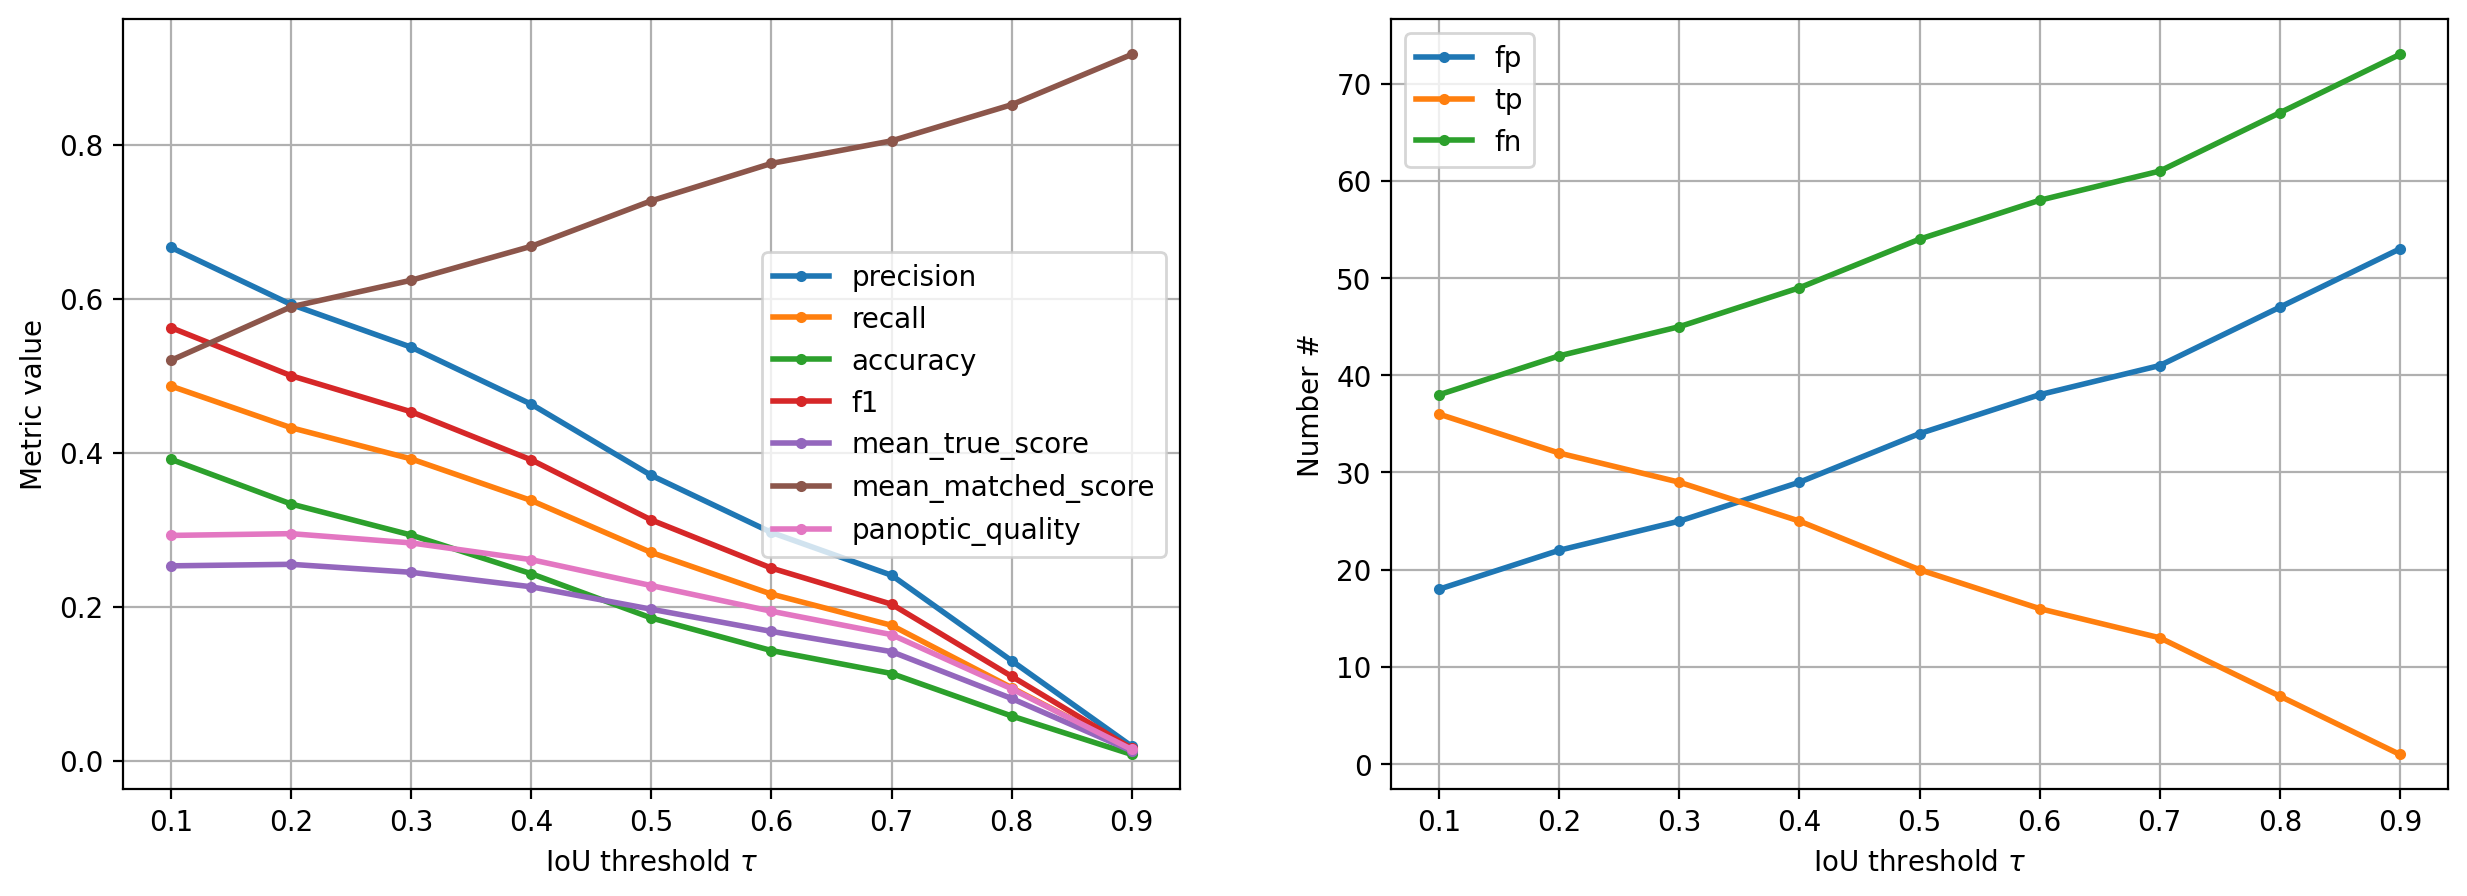

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

# Wow thats better... lol



In [ ]:
image_paths = sorted(glob('/content/drive/MyDrive/Grain Boundary Detection/Stardist/DataCollection/luisData/train/images/*.tif'))

# Read the images and masks into arrays
X = [io.imread(image_path) for image_path in image_paths]

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

IndexError: ignored

In [ ]:
# show all test images
if True:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;